# <center>***Assignment 3 for Data Analysis 3***<center>

<center>Conducted by Ian Brandenburg and Zsófia Rebeka Katona<center>
    
--------------------------------------------------------------------------------------------
    

Please find the full assignment in Ian's [GitHub Repo](https://github.com/Iandrewburg/DA3_Brandenburg/tree/main/Assignment_3)



The goal of this analysis is to develop a predictive model to identify which small or medium-sized firms in the "Manufacture of computer, electronic, and optical products" industry might fail in 2015, based on their activity in 2014.

[**Data source**](https://osf.io/b2ft9/?view_only=):
Detailed company data from a middle-sized country in the European Union
All registered companies in 2005-2016 in three selected industries 
  (auto manufacturing, equipment manufacturing, hotels and restaurants)
This rich database was constructed for from multiple publicly available sources 
by Bisnode, a business data and anlytics company www.bisnode.com
for educational purposes

Our dependent variable (*Y*) - Dummy Variable for if the company defaulted or not

#### ***Import Libraries and Helper Functions***
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from io import StringIO
from pathlib import Path
from plotnine import *
from mizani.formatters import percent_format
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, auc, brier_score_loss, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.calibration import calibration_curve
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
# Combining py helper functions with our functions

color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 1.1, 0.1))
    )

    return plot
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = (ggplot(all_coords, aes(x='fpr', y='tpr')) +
            geom_line(color='blue', size=0.7) +
            geom_area(position='identity', fill='mediumaquamarine', alpha=0.3) +
            xlab("False Positive Rate (1-Specifity)") +
            ylab("True Positive Rate (Sensitivity)") +
            geom_abline(intercept=0, slope=1, linetype="dotted", color="black") +
            scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, .1), expand=(0, 0.01)) +
            scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, .1), expand=(0.01, 0)) +
            theme_bw())
    return plot

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    # Assuming FP (False Positive cost) and FN (False Negative cost) are provided or defined earlier
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy['false_pos'] * FP + all_coords_copy['false_neg'] * FN) / all_coords_copy['n']
    
    t = optimal_threshold
    l = curr_exp_loss

    # Define colors for plotting
    line_color = 'blue'  # Line color for geom_line and geom_vline
    text_color = 'red'  # Color for annotations

    plot = (ggplot(all_coords_copy, aes(x='thresholds', y='loss')) +
            geom_line(color=line_color, size=0.7) +
            scale_x_continuous(breaks=np.arange(0, 1.1, 0.1)) +
            coord_cartesian(xlim=(0, 1)) +
            geom_vline(xintercept=t, color=line_color) +
            annotate('text', x=t - 0.01, y=max(all_coords_copy['loss']) - 0.4,
                     label=f"best threshold: {round(t, 2)}",
                     colour=text_color, angle=90, size=7) +
            annotate('text', x=t + 0.06, y=l,
                     label=str(round(l, 2)), size=7) +
            theme_bw())
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = np.arange(0, 1.1, 0.1)) +\
        scale_x_reverse(breaks = np.arange(0, 1.1, 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)


def data_sherlock(data):
    # Initialize a StringIO object to capture the output of df.info()
    buffer = StringIO()
    data.info(buf=buffer)
    data_info_str = buffer.getvalue()

    # Separator for clarity in output
    separator = "-"*50

    print(f"{separator}\nDataFrame Information Summary\n{separator}")

    # Number of rows
    rows_count = data.shape[0]
    print(f"\nRows Information\n{separator}\nTotal rows: {rows_count}")

    # Check for remaining null values
    null_count = data.isnull().sum().sum()
    print(f"\nNull Values Information\n{separator}\nTotal null values: {null_count}")

    # Check for remaining infinite values
    infinite_count = (data.replace([np.inf, -np.inf], np.nan).isna() & data.notna()).sum().sum()
    print(f"\nInfinite Values Information\n{separator}\nTotal infinite values: {infinite_count}")

    # Data types
    print(f"\nData Types\n{separator}")
    print(data.dtypes)

    # DataFrame Information captured from .info()
    print(f"\nDataFrame Detailed Information\n{separator}\n{data_info_str}")

    # Return a structured summary as a dictionary (optional)
    return {
        "rows_info": f"Total rows: {rows_count}",
        "null_info": f"Total null values: {null_count}",
        "infinite_info": f"Total infinite values: {infinite_count}",
    }



# ***Data Processing***
---

## *Import Data Directly from GitHub*
---

In [3]:
data = pd.read_csv('https://github.com/Iandrewburg/DA3_Brandenburg/raw/main/Assignment_3/cs_bisnode_panel.csv')
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
# Run the data_sherlock dataframe inspector function that we so gloriously created
data_sherlock(data)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 287829

Null Values Information
--------------------------------------------------
Total null values: 2889125

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
comp_id                 float64
begin                    object
end                      object
COGS                    float64
amort                   float64
curr_assets             float64
curr_liab               float64
extra_exp               float64
extra_inc               float64
extra_profit_loss       float64
finished_prod           float64
fixed_assets            float64
inc_bef_tax             float64
intang_assets           float64
inventories             float64
liq_assets              float

{'rows_info': 'Total rows: 287829',
 'null_info': 'Total null values: 2889125',
 'infinite_info': 'Total infinite values: 0'}

# ***Label Engineering***
---

In [5]:
# Set the index to the columns of interest
data = data.set_index(["year", "comp_id"])

# Perform the unstack operation, which will automatically introduce NaNs for missing combinations
data = data.unstack().stack(dropna=False)

# Reset the index to make 'year' and 'comp_id' regular columns again
data = data.reset_index()

# Note: The unstack() and stack(dropna=False) operations introduce NaNs for missing entries automatically.


In [6]:
# Generate status_alive; if sales are larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


# It defaults in two years if there are sales in this year but no sales two years later
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [7]:
data['status_alive'].value_counts()

0    318453
1    238491
Name: status_alive, dtype: int64

In [8]:
data['default'].value_counts()

0    507577
1     49367
Name: default, dtype: int64

In [9]:
data['default'].describe()

count    556944.000000
mean          0.088639
std           0.284222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

This concludes that 311,016 firms defaulted and 245,928 firms stayed alive, and 2 years later, 274,393 will stay alive and 13,436 firms will default.

In [10]:
data['sales'].describe()

count    2.803920e+05
mean     5.042513e+05
std      3.861890e+06
min     -1.472559e+07
25%      5.295370e+03
50%      3.280741e+04
75%      1.210056e+05
max      1.110294e+08
Name: sales, dtype: float64

In [11]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [12]:
# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


In [13]:
# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [14]:
data['new'].describe()

count    556944.000000
mean          0.680936
std           0.466114
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

This concludes that there are 556,944 new firms.

In [15]:
data.isna().sum()

year                         0
comp_id                      0
begin                   269115
end                     269115
COGS                    538687
amort                   277155
curr_assets             269246
curr_liab               269246
extra_exp               287644
extra_inc               287644
extra_profit_loss       286318
finished_prod           539459
fixed_assets            269246
inc_bef_tax             276552
intang_assets           269255
inventories             269246
liq_assets              269246
material_exp            277155
net_dom_sales           538687
net_exp_sales           538687
personnel_exp           277155
profit_loss_year        278999
sales                   276552
share_eq                269246
subscribed_cap          269246
tang_assets             270585
wages                   538961
D                       556944
balsheet_flag           269115
balsheet_length         269115
balsheet_notfullyear    269115
founded_year            325572
exit_yea

# ***Feature Engineering***
---

### *Adding more Firm Characteristics Variables*
---

In [16]:
# Adding more variables as firm characteristics
data["age2"] = data["age"] ** 2

# Grouping values for foreign_management as dummies 
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# Creating new columns for the categorical gender and and region variables
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### Looking at financial variables
---

In [17]:
# Looking at financial variables and creating new financial ratios

# As assets cannot be negative: transforming the negative asset values to 0 and flagging them
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [18]:
# Tranforming the negative asset variables to 0
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [19]:
# Generating the total assets balance sheet variable by adding up the intangible, current and fixed assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810741e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [20]:
# Collecting the profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']

# Collecting the balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

In [21]:
# Scaling the the pl_names elements by dividing them with sales and creating a new column for them
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [22]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs"
    # Replacing Infinite and NaN values with 0 in the new column
    data[new_col_name] = data[col].div(data["total_assets_bs"]).replace((np.inf, -np.inf, np.nan), 0)
    
    # Set values to NaN where total_assets_bs is NaN
    data[new_col_name] = np.where(data["total_assets_bs"].isna(), np.nan, data[new_col_name])


In [23]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs" 
    # Directly assigning the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        # If total_assets_bs is NaN, assign NaN
        np.nan, 
        # Handling division by zero by replacing NaN values resulting from division by zero with 0
        # ... and replacing Infinite values with 0
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)
    )

In [24]:
# Dividing all bs_names elements by total_assets_bs and creating new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    # Replacing Infinite values with 0
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# Getting Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )
    

### *Creating flags and winsorizing tails*
---

`Winsorizing` is dropping extreme values, usually by setting a threshold at a certain percentile in the distribution, and replacing values beyond that threshold with the threshold value itself.

In [25]:
# Creating a list for the variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

# Creating a new column for values above 1, and leaving NaN values unchanged
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
# Replacing values above 1 with 1
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
# Creating a column to flag error
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
# Replacing negative values with 0
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [26]:
# Pooling variables that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl",
         "inc_bef_tax_pl",
         "profit_loss_year_pl",
         "share_eq_bs"]

# Raplcing negative values with -1
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
# Replacing values above 1 with 1
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
# Creating a column to flag errors
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
# Creating a column for the quadratic values
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [27]:
# Dropping 'flag' columns with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


### *Defining additional financial ratios*
---

In [28]:
# Gross Profit Margin
data['gross_profit_margin'] = (data['sales'] - (data['material_exp'] + data['personnel_exp'])) / data['sales']

# Net Profit Margin
data['net_profit_margin'] = data['profit_loss_year'] / data['sales']

# Return on Equity (ROE)
data['return_on_equity'] = data['profit_loss_year'] / data['share_eq']

# Debt-Equity Ratio
# Note: we need to adjust 'curr_liab' to total liabilities if we have that information. Need to further investigate the data.
data['debt_equity_ratio'] = data['curr_liab'] / data['share_eq']

# Current Ratio
data['current_ratio'] = data['curr_assets'] / data['curr_liab']

# Quick Ratio
data['quick_ratio'] = (data['curr_assets'] - data['inventories']) / data['curr_liab']

# Return on Assets (ROA)
data['return_on_assets'] = data['profit_loss_year'] / data['total_assets_bs']


### *Including some additional imputation*
---

In [29]:
# Calculating the CEO's age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)

# Capping and imputing the missing values for CEO age
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Creating a new binary column for young CEOs
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [30]:
# Creating category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


### *Handling the sales variable (target variable)*
---

In [31]:
# Squaring the log sales
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [32]:
# Performing linear regression: deault on logarithmic sales and squared logarithmic sales
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                 1.673e+04
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:25:38   Log-Likelihood:            -1.1139e+05
No. Observations:              280392   AIC:                         2.228e+05
Df Residuals:                  280389   BIC:                         2.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0370      0.001  

The OLS regression shown here displays the unconditional regression of sales on the probability of a company defaulting. The coefficients here suggest there is an association between the probability a company will default and sales. The log sales coefficient suggests that a decrease in sales is associated with an increase in the probability that a company will default. This is statistically significant at the 1% threshold.  

#### *Change in sales*
---

In [33]:
# lowess
data["d1_sales_mil_log"].describe()

count    556944.000000
mean          0.023417
std           0.870581
min         -13.815511
25%           0.000000
50%           0.000000
75%           0.000000
max          14.634809
Name: d1_sales_mil_log, dtype: float64

## *Holdout Sample*
---

The holdout sample is filtered to the following parameters: 

- `ind2` code is 26, representing the manufacture of computer, electronic, and optical products industr<
- `sales` is filtered to be from 1,000 to 10,000,000
- `year` is set to 2014

In [34]:
# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)


In [35]:
# Filter the holdout sample 
hold_out_sample = data[(data['ind2'] == 26) &
                     (data['sales'] >= 1000) &
                     (data['sales'] <= 10000000) &
                     (data['year'] == 2014)]
hold_out_sample

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,5.598051,5.598051,0.203344,52.5,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,15.283726,13.489829,-0.027249,54.0,0,0,0,0,default,9.939450
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,0.000000,0.000000,-inf,52.0,0,0,0,0,default,30.507003
417989,2014,1.777654e+07,2014-01-01,2014-12-31,NaN,48.148148,142296.296875,164237.031250,0.0,0.0,...,0.866408,0.109056,0.010282,43.5,0,0,0,0,no_default,2.402822
417994,2014,1.862676e+07,2014-01-01,2014-12-31,NaN,5755.555664,95185.187500,45766.667969,0.0,0.0,...,2.079793,1.755847,0.053106,36.0,0,0,0,1,default,3.176648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,NaN,0.000000,40740.742188,559.259277,0.0,0.0,...,72.847682,72.847682,0.272000,39.0,0,0,0,1,default,15.972916
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,22.166201,18.601955,0.028824,55.0,0,0,0,0,no_default,6.270351
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,4.211560,3.291981,0.007774,61.0,0,0,0,0,no_default,7.099340
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2.346815,2.346815,0.068191,52.5,0,0,0,0,default,12.497002


In [36]:
# Overview the data with the data_sherlock function
data_sherlock(hold_out_sample)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1037

Null Values Information
--------------------------------------------------
Total null values: 8599

Infinite Values Information
--------------------------------------------------
Total infinite values: 43

Data Types
--------------------------------------------------
year                    int64
comp_id               float64
begin                  object
end                    object
COGS                  float64
                       ...   
flag_high_ceo_age       int32
flag_miss_ceo_age       int32
ceo_young               int32
default_f            category
sales_mil_log_sq      float64
Length: 124, dtype: object

DataFrame Detailed Information
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 417864 to

{'rows_info': 'Total rows: 1037',
 'null_info': 'Total null values: 8599',
 'infinite_info': 'Total infinite values: 43'}

In [37]:
data_2015 = data[(data['sales'] >= 1000) &
            (data['ind2'] == 26) &
            (data['sales'] <= 10000000) &
            (data['year'] == 2015)]

In [38]:
data_sherlock(data_2015)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1038

Null Values Information
--------------------------------------------------
Total null values: 8684

Infinite Values Information
--------------------------------------------------
Total infinite values: 40

Data Types
--------------------------------------------------
year                    int64
comp_id               float64
begin                  object
end                    object
COGS                  float64
                       ...   
flag_high_ceo_age       int32
flag_miss_ceo_age       int32
ceo_young               int32
default_f            category
sales_mil_log_sq      float64
Length: 124, dtype: object

DataFrame Detailed Information
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 464276 to

{'rows_info': 'Total rows: 1038',
 'null_info': 'Total null values: 8684',
 'infinite_info': 'Total infinite values: 40'}

In [39]:
# Missing values in the holdout sample
print("MISSING VALUES FROM HOLDOUT SAMPLE")
print("-"*35)
to_filter = hold_out_sample.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM HOLDOUT SAMPLE
-----------------------------------


COGS                            948
amort                             2
finished_prod                   950
material_exp                      2
net_dom_sales                   948
net_exp_sales                   948
personnel_exp                     2
wages                           949
D                              1037
founded_year                     31
exit_year                      1014
ceo_count                        31
foreign                          31
female                           31
birth_year                      114
inoffice_days                    31
gender                           31
origin                           31
region_m                          2
exit_date                      1012
labor_avg                       312
age                              31
age2                             31
foreign_management               31
gender_m                         31
m_region_loc                      2
material_exp_pl                   2
personnel_exp_pl            

### *Holdout Sample Summary Table*
---

In [40]:
hold_out_summary = {
    'Number of Firms': [hold_out_sample.shape[0]],
    'Mean Sales': [hold_out_sample['sales'].mean()],
    'Min Sales': [hold_out_sample['sales'].min()],
    'Max Sales': [hold_out_sample['sales'].max()],
    'Defaulted Firms': [hold_out_sample['default'].sum()],
    'Stayed Alive Firms': [(hold_out_sample['default'] == 0).sum()]

}

hold_out_summary_df = pd.DataFrame(hold_out_summary)
hold_out_summary_df

,Number of Firms,Mean Sales,Min Sales,Max Sales,Defaulted Firms,Stayed Alive Firms
0,1037,490202.217927,1070.370361,9576485.0,56,981


In [41]:
hold_out_sample['sales'] = pd.to_numeric(hold_out_sample['sales'], errors='coerce')

# Check the data type of the 'sales' column after conversion
print(hold_out_sample['sales'].dtype)


float64


# ***Data Cleaning***
---

Missing values fo the filtered dataset. The filtered dataset includes years 2013 and older in order to compare to the holdout sample which is only 2014. 

### *Filter Dataframe and Check Missing Values*
---

In [42]:
# Filtering the dataset to be 2010-2013, and between 1000 and 10000000
data = data[(data['sales'] >= 1000) &
            (data['ind2'] == 26) &
            (data['sales'] <= 10000000) &
            (data['year'] <= 2013) &
            (data['year'] >= 2010)]

In [43]:
# Comparing the missing values from the entire data set and data from 2014
print("MISSING VALUES FROM ENTIRE DATASET")
print("-"*35)
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM ENTIRE DATASET
-----------------------------------


COGS                 3930
amort                  13
curr_assets             1
curr_liab               1
finished_prod        3933
                     ... 
return_on_equity        2
debt_equity_ratio       3
current_ratio           3
quick_ratio             3
return_on_assets        1
Length: 77, dtype: int64

- Here, we can verify that `COGS`, `finished_prod`, `net_dom_sale`, `net_exp_sales`, and `wages` will need to be dropped from the analysis. 

- `exit_year` and `exit date` can stay since not all companies are exiting, and we are trying to predict how many companies will exit.

- The `D` column will also be dropped for it's high frequency of missing values

- Also dropping `ind` column, as it does not serve any use in this specific project.

- With `labor_avg` having such a high number of missing values, this column will also be dropped.

- `exit_year` is being dropped since we have developed metrics to determine if a company defaulted or not. Additionally, there are a large number of missing values for the `exit_year` column

### *Cleaning Function:* `data_dish_washer`
---

Cleans both the training dataframe and the holdout sample. 

In [44]:
# Creating a function to handle missing values

def data_dish_washer(data):
    # Step 1: Imputing with 0: Fill specific columns with 0 in case of numerical values
    zero_fill_cols = ['amort',
                      'curr_assets',
                      'personnel_exp', 
                      'material_exp',
                      'liq_assets',
                      'inventories',
                      'intang_assets', 
                      'fixed_assets',
                      'extra_profit_loss',
                      'extra_inc',
                      'extra_exp', 
                      'curr_liab',
                      'tang_assets']
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)


    # Step 2: Imputing with median: Fill missing values with median where it makes sense
    median_fill_cols = ['sales',
                        'profit_loss_year',
                        'inc_bef_tax', 
                        'share_eq',
                        'subscribed_cap']
    for col in median_fill_cols:
        data[col] = data[col].fillna(data[col].median())

    # Step 3: Change: Drop rows with missing values in specified categorical columns
    row_drops = ['nace_main',
                 'ind2',
                 'ceo_count', 
                 'foreign', 
                 'female',
                 'inoffice_days',
                 'gender',
                 'origin']
    data = data.dropna(subset=row_drops)

    # Step 4: Fill missing regions with 'NaN'
    data['region_m'] = data['region_m'].fillna('Missing')
    
    
    # Add "Missing" as a category for the 'm_region_loc' column
    if "Missing" not in data['m_region_loc'].astype('category').cat.categories:
        data['m_region_loc'] = data['m_region_loc'].astype('category').cat.add_categories("Missing")

    # Now you can safely replace NA values with "Missing"
    data['m_region_loc'] = data['m_region_loc'].fillna("Missing")


    # Step 5: Convert Date variables to datetime types
    datetime_columns = ['begin',
                        'end',
                        'founded_date']
    for col in datetime_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Step 6: Verify Numeric Columns
    numeric_columns = ['year',
                       'founded_year',
                       'exit_year',
                       'birth_year']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Transforming the Infinite values with NaNs in data
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # Apply fillna(0) only to numeric columns to avoid the TypeError
    data[zero_fill_cols + median_fill_cols] = data[zero_fill_cols + median_fill_cols].fillna(0)
    
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    data[numerical_columns] = data[numerical_columns].fillna(0)
    
    
    # Dropping the columns with too many missing values in the original data
    data = data.drop(columns = ['COGS',
                                'finished_prod',
                                'net_dom_sales',
                                'net_exp_sales',
                                'wages',
                                'D',
                                'ind',
                                'labor_avg',
                                'exit_date'])
    
    return data



### *Execute* `data_dish_washer` *on the training dataframe* `data`
---

Inspect for any missing values or infinite values

In [45]:
data = data_dish_washer(data)
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
232216,2010,6.538183e+06,2010-01-01,2010-12-31,59.259258,11562.962891,2085.185303,0.000000,0.000000,0.0,...,5.545293,5.545293,0.032764,46.68887,0,0,1,0,no_default,13.702598
232242,2010,8.416055e+06,2010-01-01,2010-12-31,325.925934,114774.070312,4518.518555,0.000000,0.000000,0.0,...,25.400819,22.702458,-0.008703,50.00000,0,0,0,0,no_default,5.115894
232274,2010,1.089394e+07,2010-01-01,2010-12-31,2770.370361,30466.666016,125966.656250,5344.444336,5344.444336,0.0,...,0.241863,0.145688,-0.367787,42.00000,0,0,0,0,default,44.863669
232294,2010,1.242838e+07,2010-01-01,2010-12-31,251.851852,14.814815,3059.259277,0.000000,0.000000,0.0,...,0.004843,0.004843,-232.000009,46.68887,0,0,1,0,no_default,18.347131
232341,2010,1.777654e+07,2010-01-01,2010-12-31,22044.445312,133822.218750,204200.000000,0.000000,0.000000,0.0,...,0.655349,0.109225,0.025811,40.00000,0,0,0,0,no_default,0.200026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417463,2013,4.593723e+11,2013-01-01,2013-12-31,0.000000,29992.591797,888.888916,0.000000,0.000000,0.0,...,33.741665,33.741665,0.440109,38.00000,0,0,0,1,no_default,16.543565
417553,2013,4.610112e+11,2013-01-01,2013-12-31,744.444458,57648.148438,3518.518555,0.000000,0.000000,0.0,...,16.384210,14.350526,-0.076422,54.00000,0,0,0,0,no_default,6.922360
417606,2013,4.620594e+11,2013-01-01,2013-12-31,670.370361,65170.371094,17066.666016,0.000000,0.000000,0.0,...,3.818577,2.706597,0.000837,60.00000,0,0,0,0,no_default,8.743910
417620,2013,4.623300e+11,2013-01-01,2013-12-31,0.000000,11551.851562,5174.074219,0.000000,0.000000,0.0,...,2.232641,2.232641,0.152211,51.50000,0,0,0,0,no_default,12.411447


In [46]:
# Overview the data post-cleaning with the data_sherlock function
data_sherlock(data)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 3956

Null Values Information
--------------------------------------------------
Total null values: 0

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
year                          int64
comp_id                     float64
begin                datetime64[ns]
end                  datetime64[ns]
amort                       float64
                          ...      
flag_high_ceo_age             int32
flag_miss_ceo_age             int32
ceo_young                     int32
default_f                  category
sales_mil_log_sq            float64
Length: 115, dtype: object

DataFrame Detailed Information
--------------------------------------------------
<class 'pan

{'rows_info': 'Total rows: 3956',
 'null_info': 'Total null values: 0',
 'infinite_info': 'Total infinite values: 0'}

In [47]:
# Adjust pandas display options to show more rows
pd.set_option('display.max_rows', None)
to_filter = data.isnull().sum()
missing_values_columns = to_filter[to_filter > 0]

# Display all columns with missing values and their counts
print(missing_values_columns)

Series([], dtype: int64)


### *Execute* `data_dish_washer` *on the holdout dataframe* `hold_out_sanple`
---

Inspect for any missing values or infinite values

In [48]:
hold_out_sample = data_dish_washer(hold_out_sample)
hold_out_sample

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,1.018518e+03,1.702222e+04,3.040741e+03,0.000000,0.000000e+00,0.000000e+00,...,5.598051,5.598051,0.203344,52.500000,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,4.259259e+02,1.057407e+05,6.918519e+03,0.000000,0.000000e+00,0.000000e+00,...,15.283726,13.489829,-0.027249,54.000000,0,0,0,0,default,9.939450
417942,2014,1.242838e+07,2014-01-01,2014-12-31,0.000000e+00,0.000000e+00,9.277777e+03,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,52.000000,0,0,0,0,default,30.507003
417989,2014,1.777654e+07,2014-01-01,2014-12-31,4.814815e+01,1.422963e+05,1.642370e+05,0.000000,0.000000e+00,0.000000e+00,...,0.866408,0.109056,0.010282,43.500000,0,0,0,0,no_default,2.402822
417994,2014,1.862676e+07,2014-01-01,2014-12-31,5.755556e+03,9.518519e+04,4.576667e+04,0.000000,0.000000e+00,0.000000e+00,...,2.079793,1.755847,0.053106,36.000000,0,0,0,1,default,3.176648
418109,2014,3.447888e+07,2014-01-01,2014-12-31,1.285185e+03,1.020741e+04,2.270370e+03,0.000000,0.000000e+00,0.000000e+00,...,4.495922,3.864600,0.005605,58.000000,0,0,0,0,default,20.860914
418121,2014,3.648780e+07,2014-01-01,2014-12-31,7.185185e+02,9.188889e+03,4.707407e+03,0.000000,0.000000e+00,0.000000e+00,...,1.952006,1.011015,0.134340,35.000000,0,0,0,1,default,9.587770
418197,2014,5.048110e+07,2014-01-01,2014-12-31,0.000000e+00,1.148148e+03,1.766667e+03,0.000000,0.000000e+00,0.000000e+00,...,0.649895,0.649895,-0.541935,58.000000,0,0,0,0,default,28.731667
418283,2014,7.034434e+07,2014-01-01,2014-12-31,7.481481e+02,5.424815e+04,3.741111e+04,0.000000,0.000000e+00,0.000000e+00,...,1.450055,1.450055,0.053893,58.000000,0,0,0,0,no_default,5.581742
418327,2014,8.219781e+07,2014-01-01,2014-12-31,1.311481e+04,1.400889e+05,5.768518e+04,0.000000,0.000000e+00,0.000000e+00,...,2.428507,2.428507,0.182052,58.000000,0,0,0,0,no_default,0.938353


In [49]:
# Inspect the hold_out_sample with the data_sherlock
data_sherlock(hold_out_sample)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1006

Null Values Information
--------------------------------------------------
Total null values: 0

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
year                                       int64
comp_id                                  float64
begin                             datetime64[ns]
end                               datetime64[ns]
amort                                    float64
curr_assets                              float64
curr_liab                                float64
extra_exp                                float64
extra_inc                                float64
extra_profit_loss                        float64
fixed_assets               

{'rows_info': 'Total rows: 1006',
 'null_info': 'Total null values: 0',
 'infinite_info': 'Total infinite values: 0'}

In [50]:
data_2015 = data_dish_washer(data_2015)

In [51]:
data_sherlock(data_2015)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1004

Null Values Information
--------------------------------------------------
Total null values: 0

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
year                                       int64
comp_id                                  float64
begin                             datetime64[ns]
end                               datetime64[ns]
amort                                    float64
curr_assets                              float64
curr_liab                                float64
extra_exp                                float64
extra_inc                                float64
extra_profit_loss                        float64
fixed_assets               

{'rows_info': 'Total rows: 1004',
 'null_info': 'Total null values: 0',
 'infinite_info': 'Total infinite values: 0'}

### *Descriptives Overview of* `sales` *Variable*
---

In [52]:
data['sales'].describe()

count    3.956000e+03
mean     4.422623e+05
std      1.112439e+06
min      1.000000e+03
25%      2.070833e+04
50%      6.907778e+04
75%      2.636139e+05
max      9.863998e+06
Name: sales, dtype: float64

In [53]:
# Custom function to format the describe output
def format_describe(describe_dict):

    formatted_describe = {k: '{:,.2f}'.format(v) for k, v in describe_dict.items()}
    return formatted_describe

# Format the mock describe data
formatted_sales_describe = format_describe(data['sales'].describe())
formatted_sales_describe

{'count': '3,956.00',
 'mean': '442,262.33',
 'std': '1,112,439.15',
 'min': '1,000.00',
 '25%': '20,708.33',
 '50%': '69,077.78',
 '75%': '263,613.88',
 'max': '9,863,998.00'}

With such a large range, the sales are getting automatically transformed in an unreadable way for visualizations.

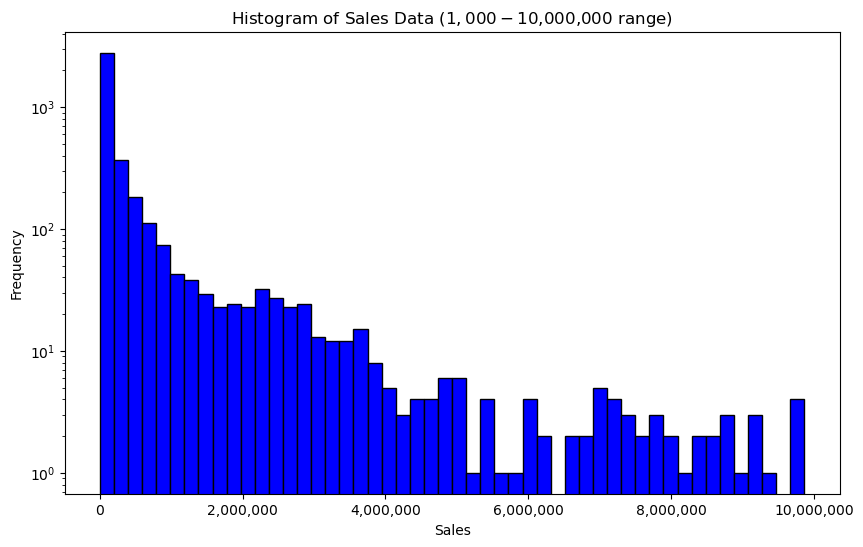

In [54]:
# Filter the data to include only sales within the specified range
filtered_sales = data['sales'][(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_sales, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Sales Data ($1,000 - $10,000,000 range)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visualization

# Set x-axis to show actual values with custom formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Create Figures folder if Figured folder does not exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder of the CWD
plt.savefig("Figures/1_sales_hist.png", format='png')

plt.show()


Fitting the sales in a range gives it a much more readable view. There is a huge skew of data, therefore log trasformation is appropriate.

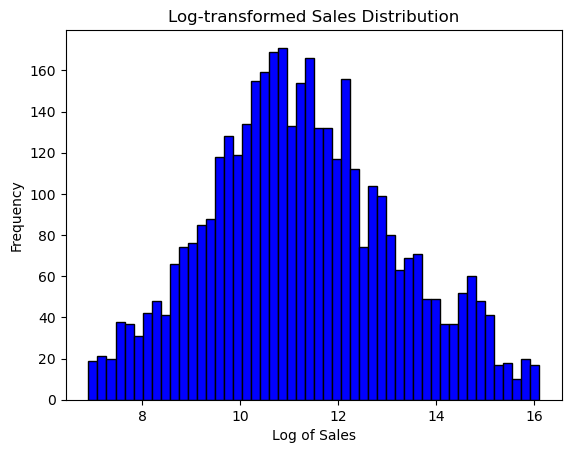

In [55]:
# Apply log transformation to sales data
data['sales_log'] = np.log1p(filtered_sales)
plt.hist(data['sales_log'], bins=50, color = 'blue', edgecolor = 'black')
plt.xlabel('Log of Sales')
plt.ylabel('Frequency')
plt.title('Log-transformed Sales Distribution')

# Create Figures folder if Figured folder does not exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder of the CWD
plt.savefig("Figures/2_log_sales_hist.png", format='png')

plt.show()


The logarithmic distribution of sales is close to a normal distribution. It is multimodal, with modes around the log values of 11 and 12. 

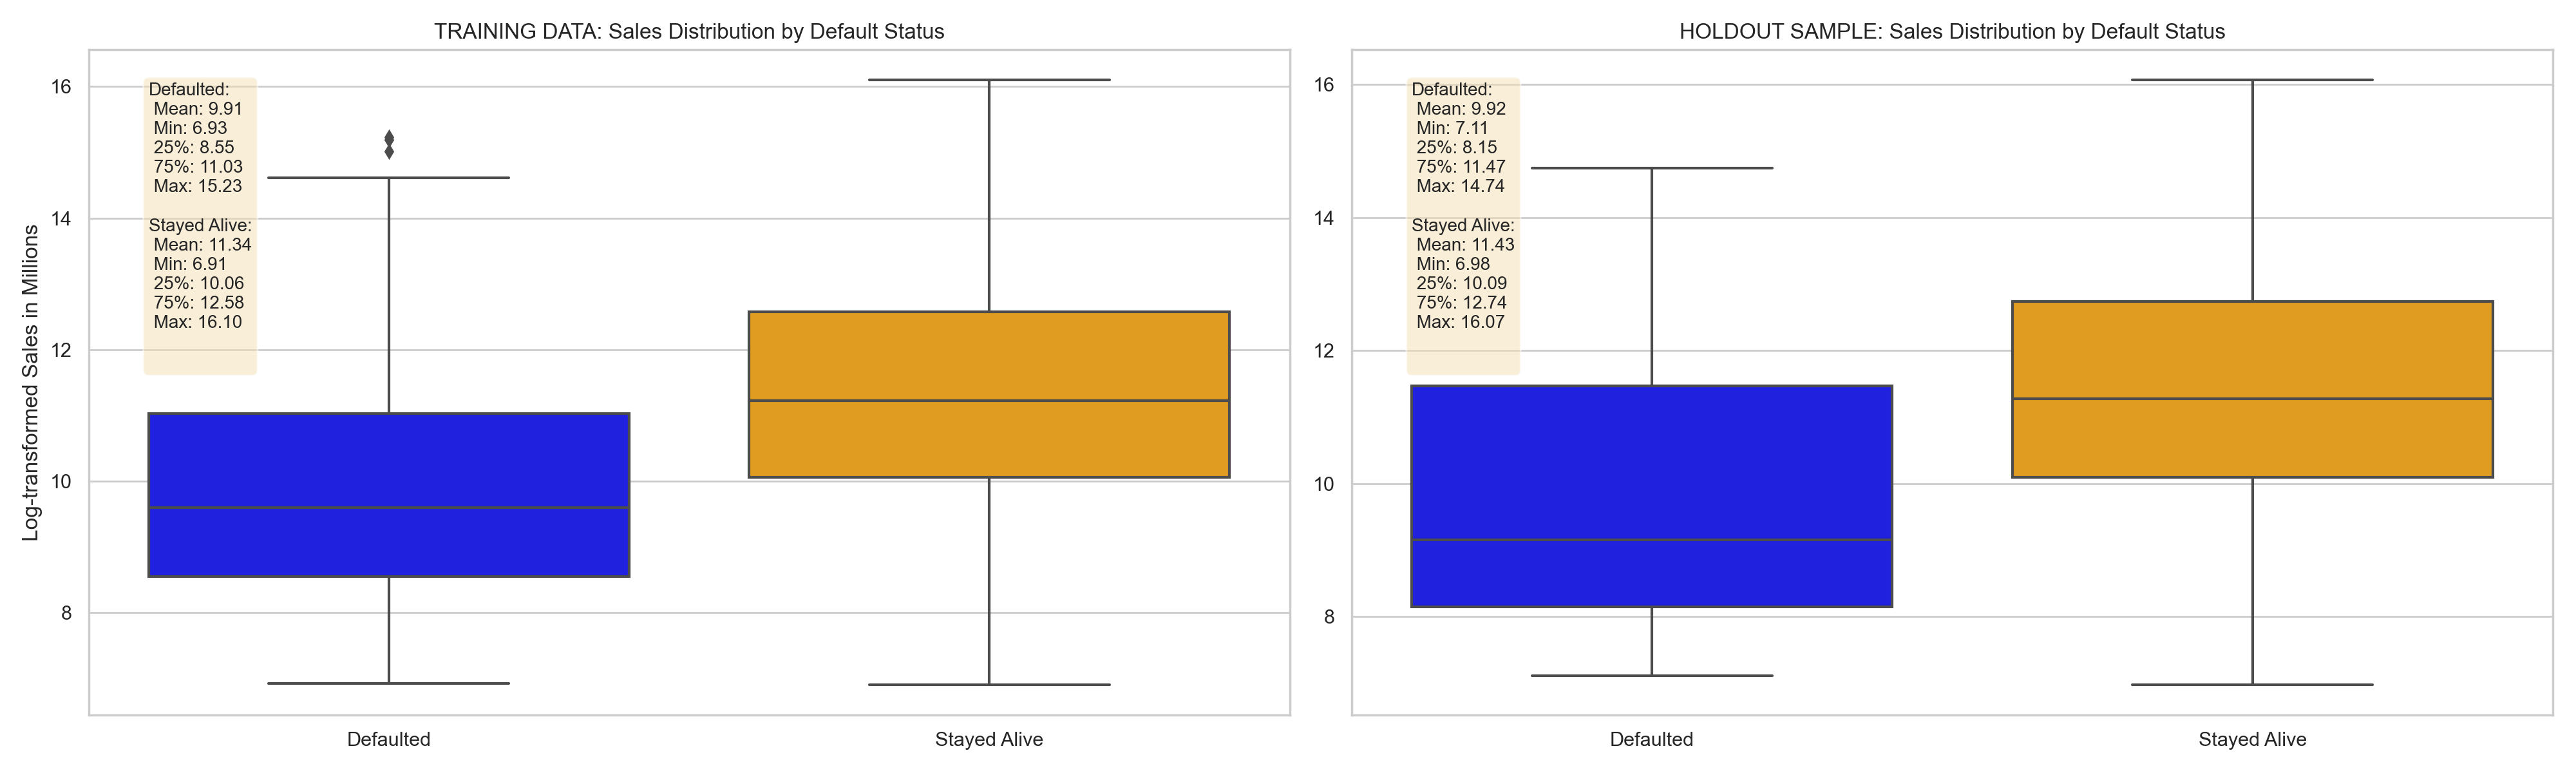

In [149]:
# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

hold_out_sample['sales_log'] = np.log1p(hold_out_sample['sales'])

# Helper function to add a stats box
def add_stats_box(ax, data, feature, groupby_feature):
    # Replace binary values with descriptive labels
    descriptive_labels = {0: 'Stayed Alive', 1: 'Defaulted'}
    data['status_label'] = data[groupby_feature].map(descriptive_labels)
    
    stats_data = data.groupby('status_label')[feature].describe()
    textstr = ''
    for key, value in stats_data.iterrows():
        textstr += f'{key}:\n'
        textstr += f' Mean: {value["mean"]:.2f}\n'
        textstr += f' Min: {value["min"]:.2f}\n'
        textstr += f' 25%: {value["25%"]:.2f}\n'
        textstr += f' 75%: {value["75%"]:.2f}\n'
        textstr += f' Max: {value["max"]:.2f}\n\n'
    
    # Position of the box inside the plot, similar to a legend
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

# Plot for TRAINING DATA
sns.boxplot(x='default', y='sales_log', data=data, order=[1, 0], palette=['blue', 'orange'], ax=axes[0])
axes[0].set_title('TRAINING DATA: Sales Distribution by Default Status')
axes[0].set_xlabel('')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Defaulted', 'Stayed Alive'])
axes[0].set_ylabel('Log-transformed Sales in Millions')
#axes[0].set_yticks([])
add_stats_box(axes[0], data, 'sales_log', 'default')

# Plot for HOLDOUT SAMPLE

sns.boxplot(x='default', y='sales_log', data=hold_out_sample, order=[1, 0], palette=['blue', 'orange'], ax=axes[1])
axes[1].set_title('HOLDOUT SAMPLE: Sales Distribution by Default Status')
axes[1].set_xlabel('')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Defaulted', 'Stayed Alive'])
axes[1].set_ylabel('')
#axes[1].set_yticks([])
add_stats_box(axes[1], hold_out_sample, 'sales_log', 'default')

# Adjust layout for better spacing
plt.tight_layout()

# Create Figures folder if Figured folder does not exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder of the CWD
plt.savefig("Figures/3_sales_default_boxplots.png", format='png')

# Show the plot
plt.show()


The box plots display the log sales figures grouped by companies who defaulted and stayed alive. As expected, the sales for operating companies compared to the defaulted companies are higher in both sets, but not substantially. Comparing the different datasets, the average sales for defaulted companies (9.91 and and 9.92) and the average sales for still operating companies (11.34 and 11.43) only differ by a few decimals. This implies that sales figures alone are not necessarily decisive in predicting whether a company will default or will keep operating. This indicates that including other variables are necessary for a more accurate prediction or assessment.

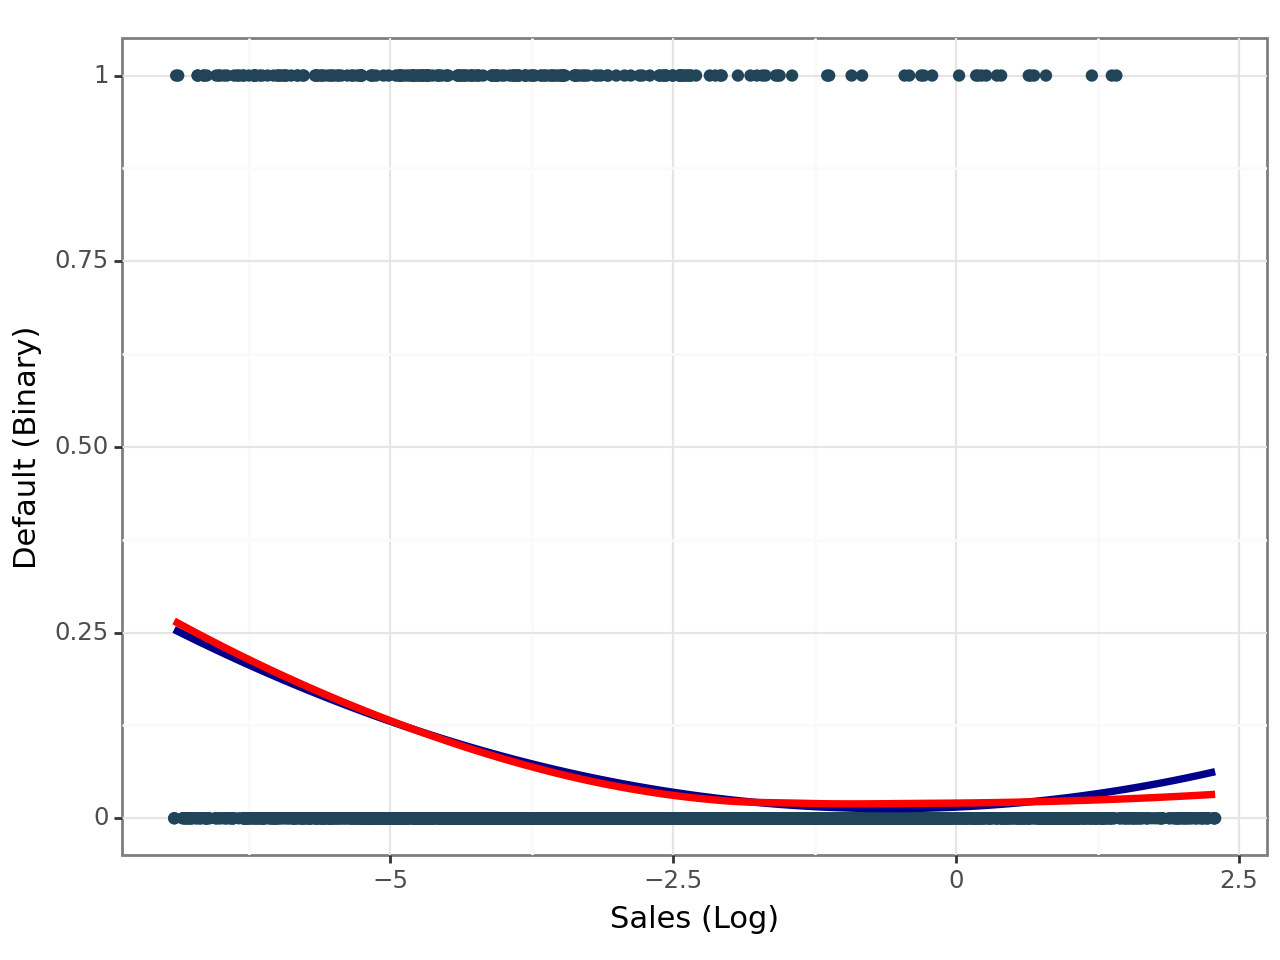

In [155]:
# Plotting the logarithmic sales and company statuses with linear regression and lowess

plot = ggplot(data, aes(x="sales_mil_log", y="default")) + geom_point(
    color="#214459"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color="darkblue", se=False, size = 1.5
) + geom_smooth(
    method="loess", color="red", se=False, size=1.5, span=0.9 
) + labs(
    x="Sales (Log)", y="Default (Binary)"
) + theme_bw()

print(plot)

# checking if figures folder exists, and if it does not, creating the figures folder
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving the plot as a PNG file
plot.save(filename="Figures/4_lowess_plot.png", format='png', height=5, width=7, dpi=100, verbose=False)

The plot for the log sales regressions and default binary shows a consistency between the linear model and the lowess method. This indicates that an increase in log sales from negative to 0 potentially means the company has stayed alive, suggesting a clear relationship between log sales and the likelihood of default. However, there is a small upward slope as log sales increase from 0, suggesting that the impact of increasing sales on reducing default risk diminishes beyond a certain threshold.

# ***Model Building***
---

### *Define Variable Sets*
---

#### Main Firm Variables
---

In [58]:
# Convert column names to a list and print
print(list(data.columns))


['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'personnel_exp', 'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'founded_year', 'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'urban_m', 'region_m', 'founded_date', 'status_alive', 'default', 'ln_sales', 'sales_mil', 'sales_mil_log', 'd1_sales_mil_log', 'age', 'new', 'age2', 'foreign_management', 'gender_m', 'm_region_loc', 'flag_asset_problem', 'total_assets_bs', 'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 'inc_bef_tax_pl', 'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl', 'intang_assets_bs', 'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'share_eq_bs', '

In [59]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap"
]

#### Further financial variables
---

In [60]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl"
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad"
]

#### Financial Ratios
---

In [61]:
financial_ratios = [
    "gross_profit_margin",
    "net_profit_margin",
    "return_on_equity",
    "debt_equity_ratio",
    "current_ratio",
    "quick_ratio",
    "return_on_assets"
]

#### Flag Variables
---

In [62]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

#### Human capital related variables
---

In [63]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "foreign_management",
]

#### Firms history related variables
---

In [64]:
firm = ["age",
        "age2",
        "new",
        "C(m_region_loc)",
        "C(urban_m)"]

#### Interactions for logit, LASSO
---

In [65]:
# Interaction terms involving financial variables
interactions1 = [
    "debt_equity_ratio * ceo_age",
    "gross_profit_margin * sales_mil",
    "intang_assets * return_on_assets",
    "foreign * current_ratio",
    "personnel_exp * sales_mil",
    "fixed_assets * return_on_equity"
]

In [66]:
# Adding interactions with log sales 
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

In [67]:
# Adding further interactions with our financial ratios
interactions3 = [
    "sales_mil_log*gross_profit_margin",
    "sales_mil_log*net_profit_margin",
    "sales_mil_log*return_on_equity",
    "sales_mil_log*debt_equity_ratio",
    "sales_mil_log*current_ratio",
    "sales_mil_log*quick_ratio",
    "sales_mil_log*return_on_assets"
]

# Adding further interactions which can affect sales of the firm
interactions4 = [
    "female*foreign_management",
    "ceo_young*share_eq_bs",
    "ceo_young*extra_profit_loss_pl",
    "origin*foreign_management",
    "female * sales_mil_log_sq"
]

## *Model Setups*
---

#### Simple Logit Models
---

In [68]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "gross_profit_margin",
    "return_on_assets"
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "gross_profit_margin",
    "return_on_assets",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs",
    "curr_liab_bs_flag_high",
    "age",
    "foreign_management"
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
    + interactions1
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
    + interactions2
)

# Adding another model with variables with the highest feature importance
M6 = [
    "flag_miss_ceo_age",
    "curr_liab_bs_flag_high",
    "fixed_assets_bs",  # Negative, but large in magnitude
    "profit_loss_year_pl_quad",
    "inc_bef_tax_pl_quad",
    "inc_bef_tax_pl",  # Negative, but large in magnitude
    "material_exp_pl_flag_high",
    "C(urban_m)",  # Negative, but large in magnitude
    "share_eq_bs",  # Negative, but large in magnitude
    "material_exp_pl",  # Negative, but large in magnitude
]


#### Logit+LASSO
---

In [69]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + financial_ratios
    + interactions1
    + interactions2
)

#### CART and RF (no interactions, no modified features)
---

In [70]:
rfvars = (
    ["sales_mil", "d1_sales_mil_log"]
    + rawvars
    + hr
    + firm
    + qualityvars
    + financial_ratios
)

#### Gradient Boosting Set
---

In [71]:
grad_boost = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
)

# ***Predictive Models***
---

## *Linear Probability Models*
---

In [72]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     14.54
Date:                Sat, 02 Mar 2024   Prob (F-statistic):           5.74e-28
Time:                        17:25:45   Log-Likelihood:                 269.83
No. Observations:                3956   AIC:                            -515.7
Df Residuals:                    3944   BIC:                            -440.3
Df Model:                          11                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0568      0.019      2.933      0.003       0.019       0.095
sales_mil_log              0.0051      0.004      1.183      0.237      -0.003       0.014
sales_mil_log_sq           0.0051      0.001      5.000      0.000       0.003       0.007
profit_loss_year_pl       -0.0134      0.025     -0.540      0.590      -0.062       0.035
gross_profit_margin        0.0021      0.005      0.421      0.674      -0.008       0.012
return_on_assets          -0.0001   3.62e-05     -3.750      0.000      -0.000   -6.48e-05
fixed_assets_bs           -0.0286      0.016     -1.802      0.072      -0.060       0.003
share_eq_bs               -0.0294      0.015     -1.964      0.050      -0.059   -6.15e-05
curr_liab_bs              -0.0067      0.020     -0.337      0.736      -0.046       0.032
curr_liab_bs_flag_high     0.0641      0.024      2.682      0.007       0.017       0.111
age                       -0.0020      0.001     -3.451      0.001      -0.003      -0.001
foreign_management         0.0342      0.013      2.548      0.011       0.008       0.060
==============================================================================
Omnibus:                     2749.750   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27189.515
Skew:                           3.404   Prob(JB):                         0.00
Kurtosis:                      13.891   Cond. No.                         593.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [73]:
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.194806
         Iterations 8


In [74]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 3956
Model:                          Logit   Df Residuals:                     3944
Method:                           MLE   Df Model:                           11
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1246
Time:                        17:25:45   Log-Likelihood:                -770.65
converged:                       True   LL-Null:                       -880.29
Covariance Type:            nonrobust   LLR p-value:                 7.288e-41
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.3638      0.336    -10.013      0.000      -4.022      -2.705
sales_mil_log             -0.1306      0.109     -1.201      0.230      -0.344       0.082
sales_mil_log_sq           0.0436      0.016      2.727      0.006       0.012       0.075
profit_loss_year_pl       -0.1099      0.225     -0.489      0.625      -0.550       0.330
gross_profit_margin        0.0460      0.060      0.763      0.445      -0.072       0.164
return_on_assets          -0.0006      0.001     -1.140      0.254      -0.002       0.000
fixed_assets_bs           -0.5414      0.277     -1.955      0.051      -1.084       0.001
share_eq_bs               -0.3321      0.209     -1.591      0.112      -0.741       0.077
curr_liab_bs               0.1585      0.338      0.469      0.639      -0.505       0.822
curr_liab_bs_flag_high     0.5111      0.290      1.764      0.078      -0.057       1.079
age                       -0.0406      0.011     -3.763      0.000      -0.062      -0.019
foreign_management         0.7283      0.206      3.540      0.000       0.325       1.132
==========================================================================================
"""

In [75]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sales_mil_log             -0.0066      0.005     -1.197      0.231      -0.017       0.004
sales_mil_log_sq           0.0022      0.001      2.728      0.006       0.001       0.004
profit_loss_year_pl       -0.0055      0.011     -0.489      0.624      -0.028       0.017
gross_profit_margin        0.0023      0.003      0.763      0.446      -0.004       0.008
return_on_assets       -3.041e-05   2.67e-05     -1.141      0.254   -8.27e-05    2.18e-05
fixed_assets_bs           -0.0273      0.014     -1.950      0.051      -0.055       0.000
share_eq_bs               -0.0167      0.011     -1.590      0.112      -0.037       0.004
curr_liab_bs               0.0080      0.017      0.468      0.639      -0.025       0.041
curr_liab_bs_flag_high     0.0258      0.015      1.762      0.078      -0.003       0.054
age                       -0.0020      0.001     -3.726      0.000      -0.003      -0.001
foreign_management         0.0367      0.010      3.510      0.000       0.016       0.057
==========================================================================================
"""

### *Predicting probabilities with logit and Lasso with CV*
---

In [76]:
# made a copy just for the purpose of making the code easier to read
data_train = data.copy()

In [77]:
# Setting the number of folds to 5
k = KFold(n_splits=5, shuffle=True, random_state=42)

### *Cross validating logit models*
---

In [78]:
# Setting up X-vars
logit_model_vars = [M1, M2, M3, M4, M5, M6]

In [79]:
# Setting up Logit model object

# Setting the C value to a very high value turns off regularization,
# ... allowing the logistic model to fit the training data as closely as possible
C_value_logit = [1e20]

In [80]:
logit_models = dict()
CV_RMSE_folds = dict()

start_time = time.time()

for i, model_vars in enumerate(logit_model_vars):
    start_iteration_time = time.time()

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)
    
    
    LRCV_brier = LogisticRegressionCV(
        # No regularization
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        # Setting the toleralization for the optimization
        tol=1e-7,
        random_state=42,
    )
    
    # Fitting the Brier model to the training data and naming the models
    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculating RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )
    
    end_iteration_time = time.time()

    print(f"Model M{i+1} completed. Time taken: {end_iteration_time - start_iteration_time:.2f} seconds.")
    
total_time = time.time() - start_time
print(f"All models completed. Total time taken: {total_time:.2f} seconds.")

Model M1 completed. Time taken: 0.24 seconds.
Model M2 completed. Time taken: 0.40 seconds.
Model M3 completed. Time taken: 1.61 seconds.
Model M4 completed. Time taken: 3.83 seconds.
Model M5 completed. Time taken: 4.08 seconds.
Model M6 completed. Time taken: 0.12 seconds.
All models completed. Total time taken: 10.29 seconds.


In [81]:
# Checking out the RMSE values
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,M6
0,0.234284,0.234167,0.234823,0.232296,0.230047,0.235387
1,0.231376,0.230469,0.232167,0.232704,0.227570,0.231733
2,0.211670,0.212704,0.211624,0.215128,0.211772,0.207936
3,0.253208,0.248926,0.248310,0.257432,0.247569,0.245632
4,0.216818,0.216427,0.217407,0.224842,0.213111,0.216602


### *Logit + LASSO*
---

In [82]:
# Adding the logit lasso variables to our model equation
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [83]:
# Scaling the variables
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [84]:
# Setting up a list of C values
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength --> smaller C values mean stronger regularization

In [85]:
# Performing another linear regression with CV
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    # Using LASSO as penalty
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

# Fitting the LASSO model to the training data
logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [86]:
# Summarizing the regularization parameters
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.003160,0.254986
1,0.046416,0.006807,0.238575
2,0.021544,0.014666,0.229371
3,0.010000,0.031598,0.226267
4,0.004642,0.068075,0.226294
5,0.002154,0.146663,0.226970
6,0.001000,0.315976,0.227285
7,0.000464,0.680749,0.228504
8,0.000215,1.466629,0.230342
9,0.000100,3.159757,0.232035


In [87]:
# Returning the index of the minimum mean cv score as we will need it later
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [88]:
# Calculating the RMSE of the models
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [89]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,M6,LASSO
0,0.234284,0.234167,0.234823,0.232296,0.230047,0.235387,0.229624
1,0.231376,0.230469,0.232167,0.232704,0.227570,0.231733,0.227242
2,0.211670,0.212704,0.211624,0.215128,0.211772,0.207936,0.210647
3,0.253208,0.248926,0.248310,0.257432,0.247569,0.245632,0.248321
4,0.216818,0.216427,0.217407,0.224842,0.213111,0.216602,0.213500


## *AUC, Calibration Curve, Confusion Matrix, ROC*
---



In [90]:
# First, we calculate AUC for logits
CV_AUC_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        # No regularization
        Cs=C_value_logit,
        cv=k,
        refit=True,
        # Setting the scoring to ROC and AUC
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    
    # Fitting the model to the training set
    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculating AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [91]:
# Now, we calculate AUC for Lasso
logLasso_auc = LogisticRegressionCV(
    # Using the C values
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)

# Fitting the Lasso model to the training data
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

# Computing AUC for the LASSO model based on CV scores 
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [92]:
# Creating a data frame for model fits
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [93]:
# Calculating the number of coefficients for the LASSO model
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

19

In [94]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

19

In [95]:
# Summarizing the model performance
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,6,0.229471,0.719717
M2,12,0.228539,0.754033
M3,26,0.228866,0.741943
M4,86,0.232480,0.732913
M5,79,0.226014,0.769907
M6,12,0.227458,0.733060
LASSO,19,0.225867,0.776757


### *Taking the best model and estimating RMSE on holdout*
---

The models with the lowest RMSE scores are LASSO (*0.225*), M5 (*0.226*) and M6 (*0.227*). Models with the highest AUC scores are LASSO (*0.777*), M5 (*0.77*) and M2 (*0.75*). Looking at both the RMSE and AUC scores, LASSO and M2 performed the best. However, considering the number of variables, we opted for M2, since it had 12 variables. while has had 19.

# This need to be changed!

In [96]:
# Preapring the holdout sample by creating a design matrix of independent variables
best_logit = logit_models["M2"]

# Constructing a formula string for the model
model_equation = "default~" + "+".join(M2)

# Ignoring the design matrix for the dependent variable as it is not needed
_, X_holdout = patsy.dmatrices(model_equation, hold_out_sample)

In [97]:
hold_out_sample["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(hold_out_sample["best_logit_pred_proba"], hold_out_sample["default"]), 3)

0.208

## *Calibration curve*
---
How well do estimated vs actual event probabilities relate to each other?


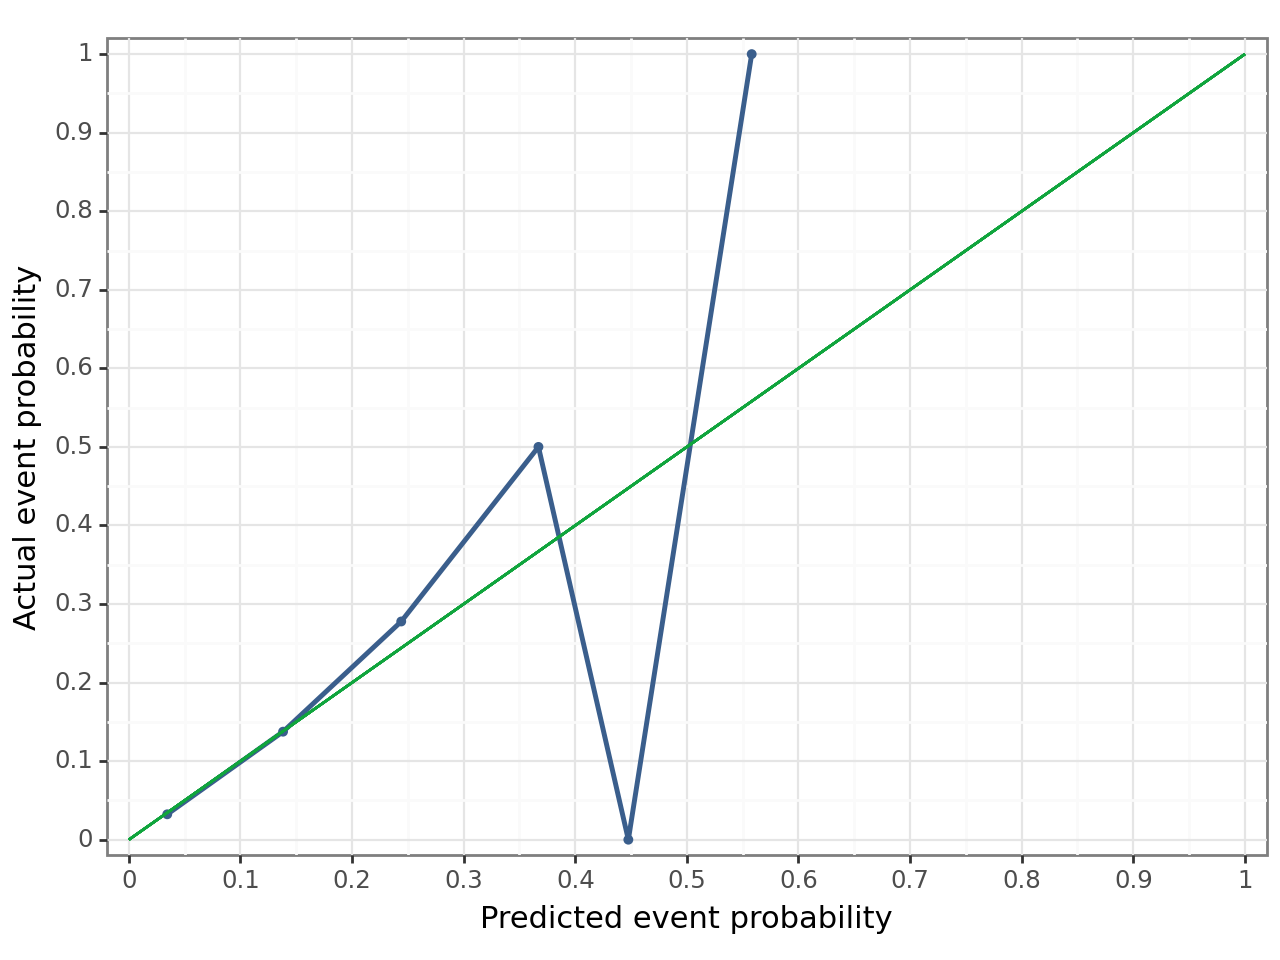

<Figure Size: (640 x 480)>

In [98]:
# Plotting the calibration curve
create_calibration_plot(
    hold_out_sample,
    file_name="logit-m2-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


The highest predicted event probability is around 0.55, cutting the calibration curve relatively short. The actual event probability decreases when the predicted event probability ranges from 0.37 until 0.45. This implies that the model is overconfident in predicting event probabilities for these cases. The actual event probability is zero when the predicted event probability reaches 0.45, suggesting that the model predicts an event with high certainty, but it doesn't actually occur for these cases. From that point, as predicted event probabilty starts to increase, the actual event probability starts to rise, but only until predicted event probability becomes 0.55 when the actual event probability equals exactly to 1. This plot suggests that while the model is performing well in general, it tends to be a bit overly confident, particularly with cases with lower predicted event probabilities.

### *Confusion table with different tresholds*
---

- The deault is setting the threshold 0.5 which is used to convert probabilities to binary classes

In [99]:
# Making predictions on the hold out dataset using the trained regression model 
logit_class_prediction = best_logit.predict(X_holdout)

# Counting the unique values in the logit class prediction
values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  1004
1.0  (default):  2


In [100]:
# Setting up the confusion matrix
# ... in our case, positive class means the deafulted companies
cm_object1 = confusion_matrix(
    hold_out_sample["default"], logit_class_prediction, labels=[0, 1]
)

# Naming the columns and rows
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1

,Predicted no default,Predicted default
Actual no default,956,0
Actual default,48,2


In [101]:
# Applying different thresholds

# Setting 0.1: The lower we set the threshold, the more FP and less FN we get
holdout_prediction = np.where(hold_out_sample["best_logit_pred_proba"] < 0.7, 0, 1)
cm_object1b = confusion_matrix(
    hold_out_sample["default"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1b

,Predicted no default,Predicted default
Actual no default,956,0
Actual default,50,0


In [102]:
# Calculating the mean threshold value
mean_predicted_default_prob = np.mean(hold_out_sample["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.051

In [103]:
# Comparing the predicted probability with the threshold value
# Probabilities less then the threshold: negative class (0)
# Probabilitites more than the threshold: positive class (1)
holdout_prediction = np.where(
    hold_out_sample["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    hold_out_sample["default"], holdout_prediction, labels=[0, 1]
)

# Creating the data frame for the confusion matrix
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm2

,Predicted no default,Predicted default
Actual no default,707,249
Actual default,17,33


### *Visualize ROC (with thresholds in steps) on the holdout set*
---

In [104]:
# First, discrete ROC (with thresholds in steps) on holdout
# Comparing multiple thresholds by setting the threshold from 0.05 until 0,76 with a 0.05 step size
thresholds = np.arange(0.05, 0.76, 0.05)

#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()

true_positive_rates = []
false_positive_rates = []
holdout_prediction = []

# Looping through the thresholds
for thr in thresholds:
    
    holdout_prediction = np.where(hold_out_sample["best_logit_pred_proba"] < thr, 0, 1)
    # Specifying the labels as 0,1 to ensure the order of the classes
    cm_thr = confusion_matrix(hold_out_sample["default"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    # Calculating the true positive rates (TPR) and the false positive rates (FPR)
    tn, fp, fn, tp = cm_thr.ravel()
    # Calculating the Sensitivity
    true_positive_rates.append(tp / (tp + fn))
    # Calculating the (1-Specificity)
    false_positive_rates.append(fp / (fp + tn))

In [105]:
# Creating a DataFrame to plot the values
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)
tpr_fpr_for_thresholds

,thresholds,true_positive_rates,false_positive_rates
0,0.05,0.66,0.268828
1,0.10,0.42,0.092050
2,0.15,0.22,0.047071
3,0.20,0.20,0.019874
4,0.25,0.14,0.011506
5,0.30,0.10,0.006276
6,0.35,0.08,0.006276
7,0.40,0.04,0.003138
8,0.45,0.04,0.001046
9,0.50,0.04,0.000000


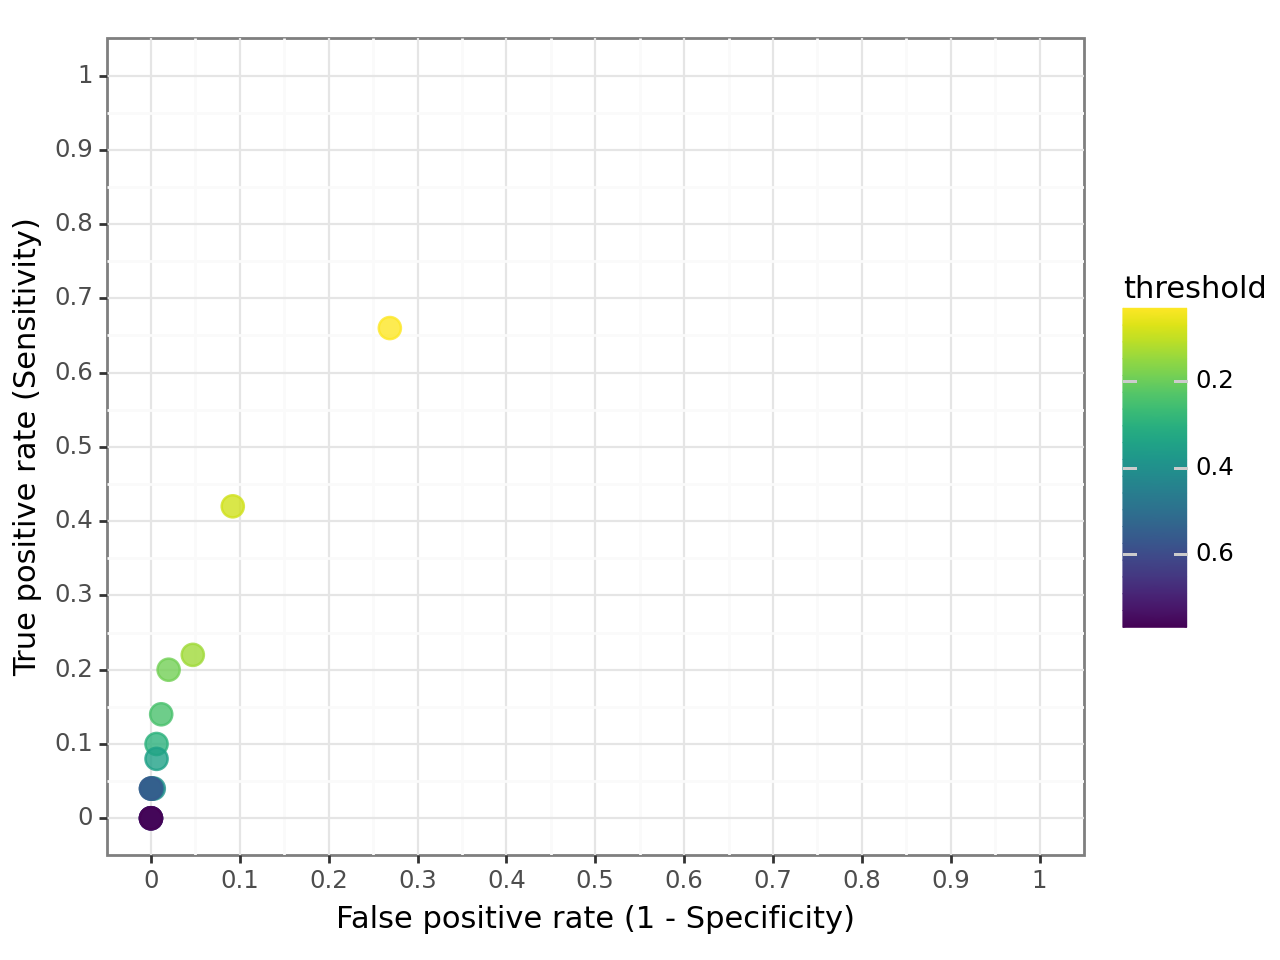

In [106]:
# Plotting the ROC curve
plot = (
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

print(plot)

# checking if figures folder exists, and if it does not, creating the figures folder
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving the plot as a PNG file
plot.save(filename="Figures/6_ROC_threshold_plot.png", format='png', height=5, width=7, dpi=100, verbose=False)

#### Interpreting the ROC curve

Our ROC curve represents a good predicting power. A conscpiciuous feature is that our highest FP rate is 0.268828, cutting the ROC curve relatively short. This can imply that our model's specificity is high, indicating that is good at identifying negative cases early on. However, it can also imply that our threshold is set too high, hence it's better to look at the continous ROC curve for more answers.

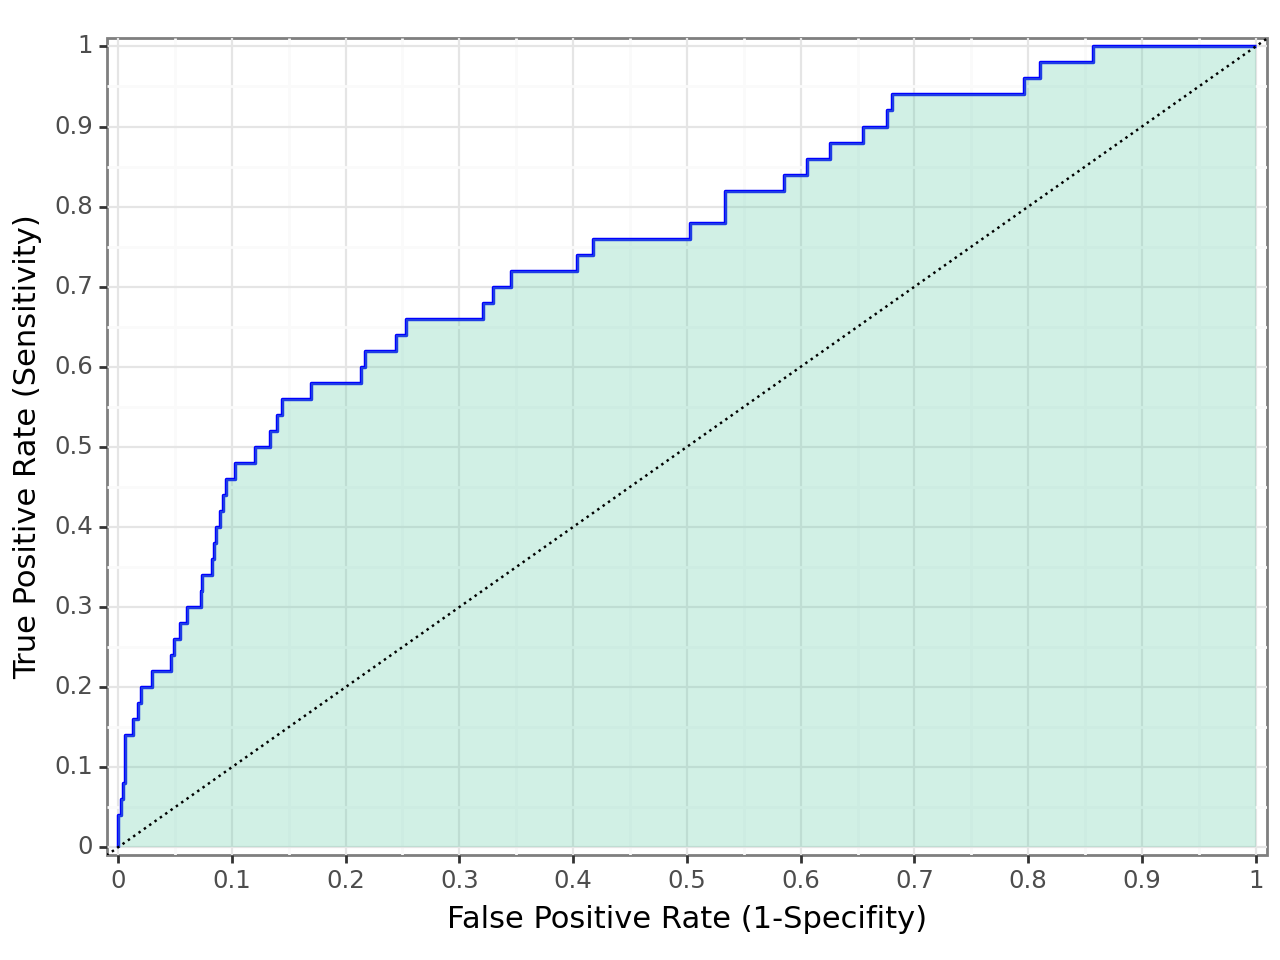

<Figure Size: (640 x 480)>

In [107]:
# Plotting the continous ROC curve (plot 8)
color = 'red'
create_roc_plot(hold_out_sample["default"], hold_out_sample["best_logit_pred_proba"])

#### Interpreting the continous ROC curve

This plot shows a better, more detailed curve than the previous one. Our continous ROC curve is notably higher than the 45 degree line which represents the 50% chance at correctly identifying negative cases (random guessing). The plot also shows that our TPR increase faster when our FPR is low, namely between 0 and 0.2. This suggests that our model is strong at correctly identifying positive cases early on, with a relatively few incorrect identifications of negative cases. Further down the curve, we can see a faster and greater increase in FPR when our TPR is higher, ranging between 0.65 to 1. This means that as soon as TPR increases beyond 0.65, the model becomes more sensitive and capable of noticing a higher number of positive cases, at the cost of a higher FPR. Therefore, the model becomes worse in prediction, resulting in more incorrect identifications of negative cases. This curve perfectly captures the trade off in how an increasing TPR results in more incorrect classifications of negative cases. Intepreting this curve in terms of our data, this means that our model might be excellent at identifying defaulting firms, it should be used cautiously, especially when minimizing false alarms (misclassifying non-defauling firms) is crucial.

## *Loss function*
---

By setting the FP to 3 and the FN to 15, we can define a cost function for our binary classification. This cost function means that the FN is considered 5 times more costly than the FP. False negative cases in our analysis mean that we predicted no default, but the firm defaulted, resulting in a bigger loss.

In [108]:
# Setting the FP to 1 and the FN 10 to define a cost function
FP = 3
FN = 15
cost = FN / FP

In [109]:
# Calculating the positive classes
prevelance = y_train.sum() / len(y_train)

Setting the expected loss parameters:
- Calculating the positive classes (above the threshold) representing the fraction of positive instances in the training data
- This ratio provides insight into class distribution and imbalance
- This can be used for model evaluation later

We are drawing an ROC Curve and finding the optimal threshold with the loss function:

- In other words, this step is part of a cross-validation procedure for selecting optimal thresholds for binary classification models and evaluating their performance using expected loss
- The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

In [110]:
# Initialization of dictionairies
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

# Iterating over each model
for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []
    
    # If the model is not LASSO, it prepares the design matrices and sets the index for cv to 0
    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
        
    # LASSO model: X is normalized_logitvars and sets the best lambda as the index
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    
    # We iterate these models over each fold of the CV
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]
        # Generating fold prediction for the current fold using the specified model
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        # Calculating the ROC curve and calculating the optimal threshold based on a loss function
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1
    # Storing best thresholds and the expected loss
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # Storing best thresholds and the expected loss for Fold 5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )
    
    # Storing all ROC curve estimates for Fold 5
    fold5_all_coords[model_name] = all_coords

In [111]:
# Summarizing the average expected loss, the threshold and th expected loss for Fold 5
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [112]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.145796,0.132010,0.789422,0.724399
1,M2,0.168825,0.259543,0.759846,0.701643
2,M3,0.150263,0.190376,0.770463,0.682680
3,M4,0.142701,0.147552,0.777281,0.671302
4,M5,0.123653,0.138855,0.745446,0.697851
5,M6,0.171528,0.249832,0.746953,0.667509
6,LASSO,0.135601,0.132717,0.747717,0.659924


### *Creating a loss plot based on Fold5 in CV*
---

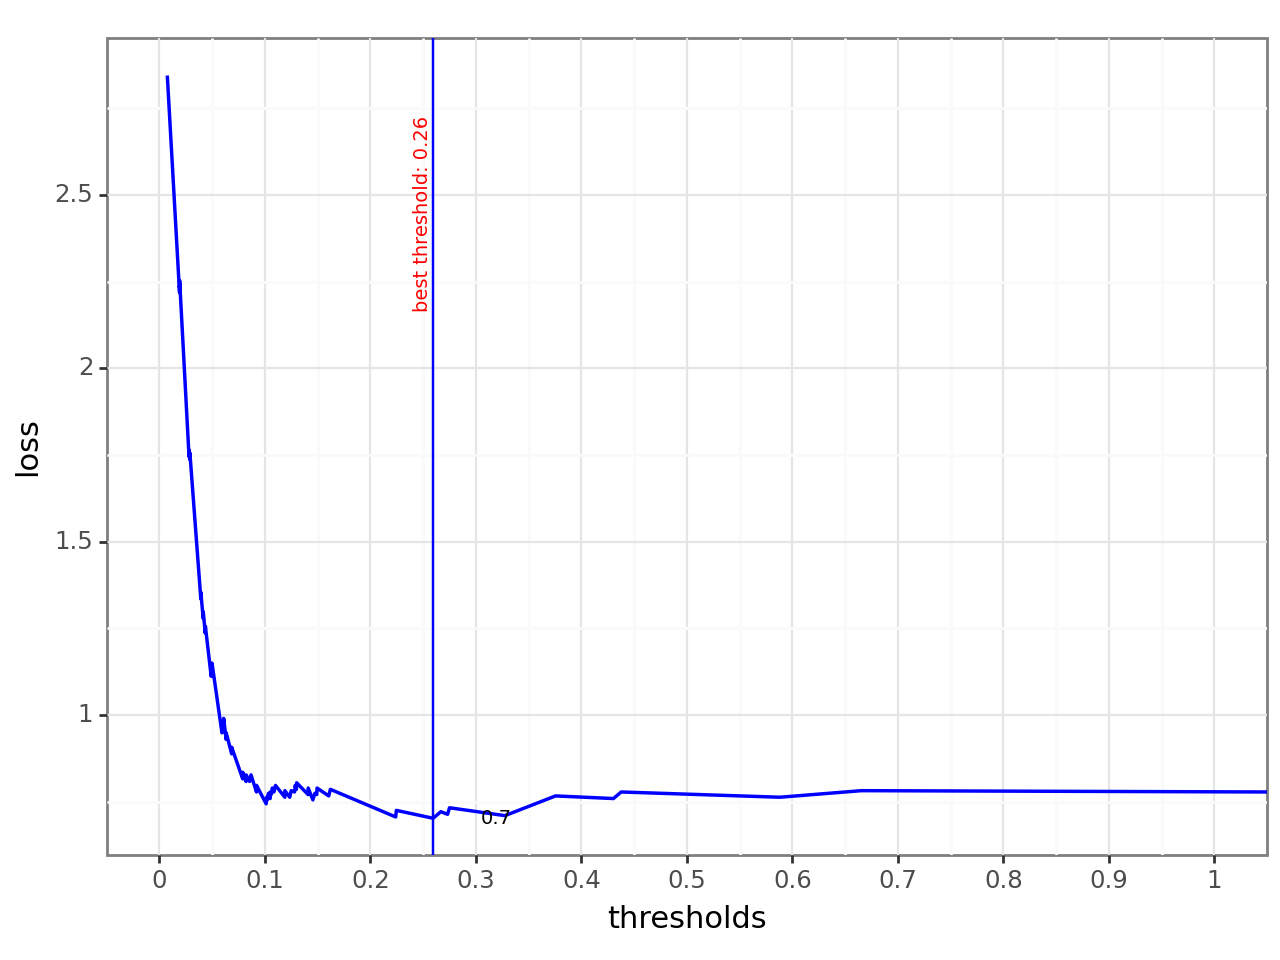

<Figure Size: (640 x 480)>

In [113]:
# Creating the loss plot based on based on Fold5 in CV
model_to_plot = "M2"  # Selecting our best model
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

#### Interpreting the plot of loss vs. threshold for M2

The graph shows that for Model 2 for Fold5, setting the threshold to 0.26 minimizes the loss, hence it is the best threshold for this model according to the loss function used.

The loss values for higher threshold values are maximized around 0.5, but they are the lowest between 0.2 and 0.3, indicating the best performance. This means that when the threshold is in that range, the model's predictions are closer to the actual values.

The sudden large drop in expected loss means that our model becomes the more sensitive at detecting positive cases (the change in sensitivity) when we set our threshold from 0 to 0.26. This sudden decrease also reflects the model's response to changing the threshold from 0.

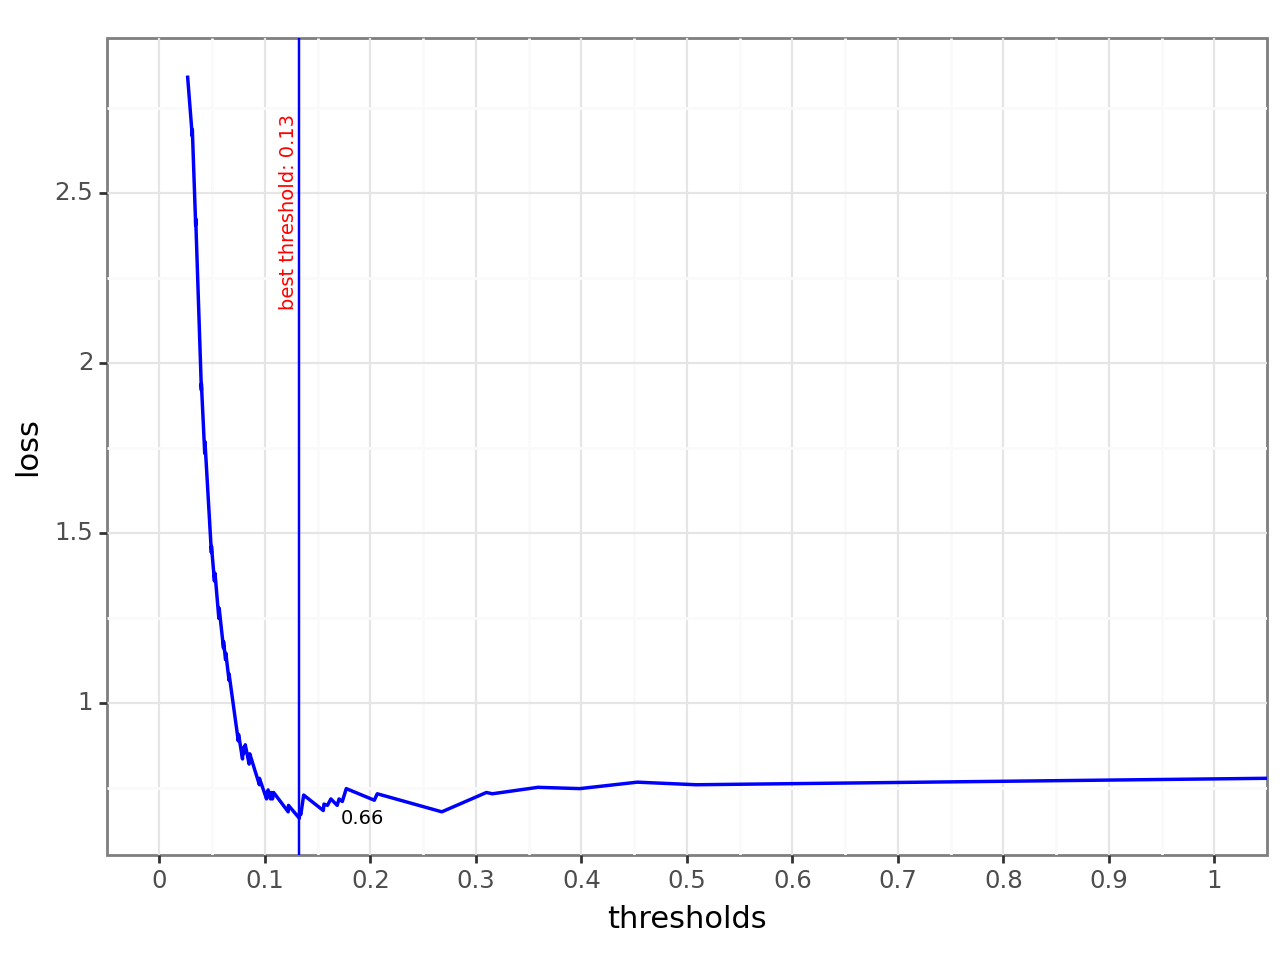

<Figure Size: (640 x 480)>

In [114]:
# Creating a second loss plot for threshold comparison
model_to_plot_2 = "LASSO"  # Selecting our second best model
create_loss_plot(
    fold5_all_coords[model_to_plot_2],
    fold5_threshold[model_to_plot_2],
    fold5_expected_loss[model_to_plot_2],
)

#### Interpreting the plot of loss vs. threshold for the LASSO model

The graph shows that for the LASSO model for Fold5, setting the threshold to 0.13 minimizes the loss, hence it is the best threshold for this model according to the loss function used.

The loss values for higher threshold values are maximized around 0.5, but they are the lowest between 0.1 and 0.13, indicating the best performance. This means that when the threshold is in that range, the model's predictions are closer to the actual values.

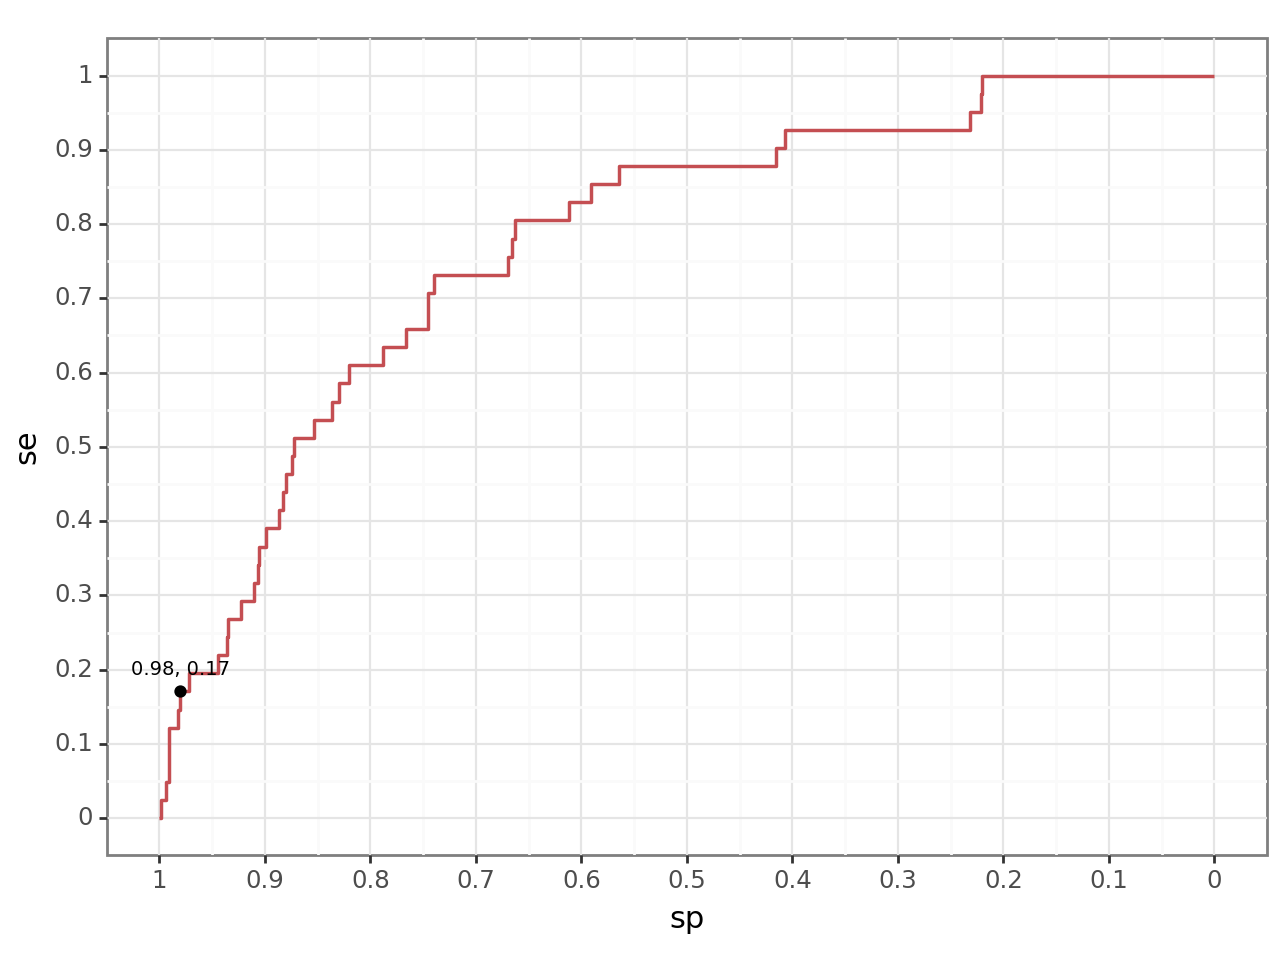

<Figure Size: (640 x 480)>

In [115]:
# Creating ROC plot based on Fold 5 in CV with optimal threshold
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


The point on the ROC curves shows the coordinates of the best optimal threshold for M2, where the Specificity score is 0.98 and the Sensitivity score is 0.17. The x scale is backwards as the x axis on the original ROC curve graph is displayed as (1-Specificity).

### *Checking our chosen model's (M2) holdout expected loss*
---

In [116]:
# Finding the best optimal threshold
best_logit_optimal_treshold = best_thresholds_cv["M2"]

# Applying the optimal threshold on the holdout sample
holdout_treshold = np.where(
    hold_out_sample["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
# If the predicted probability is less than the threshold --> assigns 0 (no default)

# Computing the confusion matrix using the true labels and the predicted labels
tn, fp, fn, tp = confusion_matrix(
    hold_out_sample["default"], holdout_treshold, labels=[0, 1]
).ravel()

# Calculating the expected loss on the holdout sample
# len() computes the expected loss on the holdout sample using fp and fn weighted by their respective costs
# Then it divides the total loss by the total number of observations in the holdout sample
expected_loss_holdout = (fp * FP + fn * FN) / len(hold_out_sample["default"])
round(expected_loss_holdout, 3)

0.68

### *Confusion matrix on the holdout sample*
---

In [117]:
# Confusion matrix on the holdout set with the holdout_threshold
cm_object3 = confusion_matrix(hold_out_sample["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actual no default,923,33
Actual default,39,11


# ***Prediction with RandomForest***
---

In [118]:
# Creating design matrices for RF, variables extracted from the training set
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train)

# Creating design matrices for RF, variables extracted from the holdout sample
y_holdout, rfvars_holdout = patsy.dmatrices("default~" + "+".join(rfvars), hold_out_sample)

## *Graph Decision Tree*
---

<Figure size 640x480 with 0 Axes>

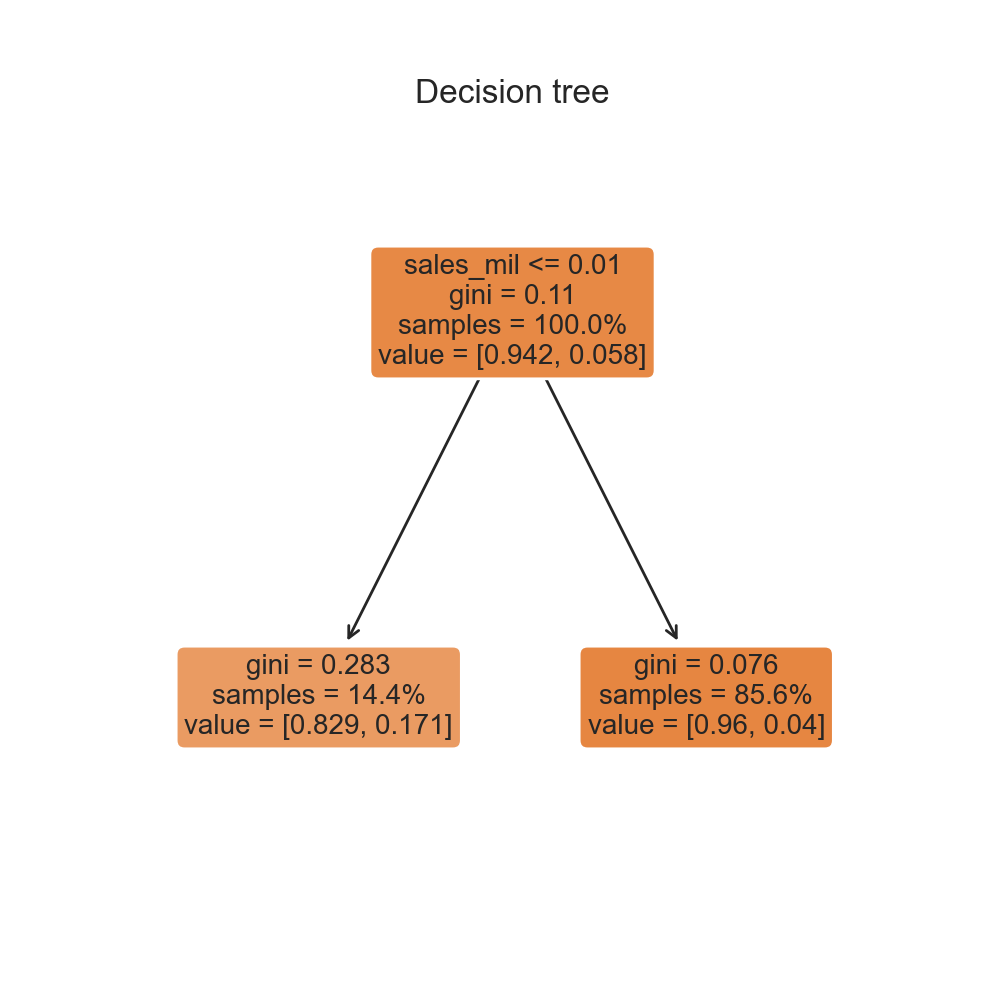

In [119]:
# Selecting the data for visualization
# We added further variables to the decision tree, however the tree didn't split the data in more depth
data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management",
                            "gross_profit_margin", "profit_loss_year_pl", "return_on_assets"]]


# Training the decision tree classifier on the selected subset features and the target variable
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

# Plotting the decision tree
plt.figure()
plt.figure(figsize=(5, 5))
plot_tree(
    rf_for_graph,
    feature_names=list(data_for_graph.columns),
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)

# Plotting the title
plt.title("Decision tree")

# Creating Figures folder if Figured folder does not exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder of the CWD
plt.savefig("Figures/9_decision_tree.png", format='png')

plt.show()


### Interpreting our decision tree

Our decision tree consists of one terminal node and two other nodes. Despite setting the `max_depth` to 3, our tree has only two branches and splits the data once. The impurity of the terminal node is higher, the other nodes represent more homogeneous subsets of the data hence the lower gini indexes. The larger sample size on the right indicates that more data points contribute to the decision made at that node.
In the left sample, approximately 82.9% of the instances belong to class 0 (stayed alive), while around 17.1% belong to class 1 (defaulted). In the larger sample, the ratio shifts, with approximately 96% of instances belonging to class 0 and 4% belonging to class 1, indicating that 96% of the companies in that subset stayed alive.

After training the decision tree with 3 variables, `sales_mil`, `profit_loss_year`, `foreign_management`, - later in the assignment - we looked at our best model's (M2) feature importance values which were `gross_profit_margin`, `profit_loss_year_pl`, `return_on_assets`. Despite adding variables with the highest feature importance, our decision tree remained the same. This indicates that while certain features may have high importance in M2, their predictive power may not translate well to other types of models.

## ***Probability Forest***
---

### Hyperparameter tuning/GridSearch

- For each combination of hyperparameters, the RandomForest algorithm is fitting multiple decision trees and evaluates their performance based on gini, our specified criteria
- Averaging over trees refers to aggregating the predictions made by each individual decision tree in the ensemble to produce a final prediction

In [120]:
# Creating a grid to search through the specified hyperparameter combinations during model training
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

In [121]:
# Setting a 5 Fold cross-validation
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [122]:
import threading

# Providing periodic updates on the time elapsed, allowing to monitor the execution process
def print_periodic_update():
    start = time.time()
    while True:
        time.sleep(30)  # Update every 30 seconds
        elapsed = time.time() - start
        print(f"Still running... {elapsed:.2f} seconds elapsed.")
        if not is_running:
            break

# Controlling a thread for periodic updates
is_running = True

# Starting the update thread
update_thread = threading.Thread(target=print_periodic_update)
update_thread.start()

# Starting the overall timer
start_time = time.time()

# Starting the GridSearchCV fitting process
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

# Stopping the update thread after the fitting is complete
is_running = False
update_thread.join()

# Stopping the timer
end_time = time.time()

# Calculating the total duration of GridSearch fitting
duration = end_time - start_time

print(f"GridSearchCV fitting completed in {duration} seconds.")


Still running... 30.00 seconds elapsed.
Still running... 60.00 seconds elapsed.
Still running... 90.00 seconds elapsed.
Still running... 120.00 seconds elapsed.
Still running... 150.01 seconds elapsed.
Still running... 180.01 seconds elapsed.
Still running... 210.01 seconds elapsed.
Still running... 240.01 seconds elapsed.
Still running... 270.01 seconds elapsed.
Still running... 300.01 seconds elapsed.
Still running... 330.01 seconds elapsed.
Still running... 360.01 seconds elapsed.
Still running... 390.01 seconds elapsed.
GridSearchCV fitting completed in 390.00937056541443 seconds.


In [123]:
# Summarizing the RF results in a DataFrame
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.806182,0.222635
1,5,16,0.804390,0.222993
2,6,11,0.806722,0.222828
3,6,16,0.804606,0.223148
4,7,11,0.802724,0.223250
5,7,16,0.804371,0.223149


In [124]:
# Defining the best parameters for the RF model
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

# We are using this hyperparameters to train the final model on the entire training set

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 11}

## ***Feature importance for RandomForest***
---

                   Feature  Importance
3      gross_profit_margin    0.142118
2      profit_loss_year_pl    0.124894
4         return_on_assets    0.122935
0            sales_mil_log    0.122526
1         sales_mil_log_sq    0.116659
5          fixed_assets_bs    0.105315
6              share_eq_bs    0.092971
7             curr_liab_bs    0.080715
9                      age    0.074832
10      foreign_management    0.010382
8   curr_liab_bs_flag_high    0.006653


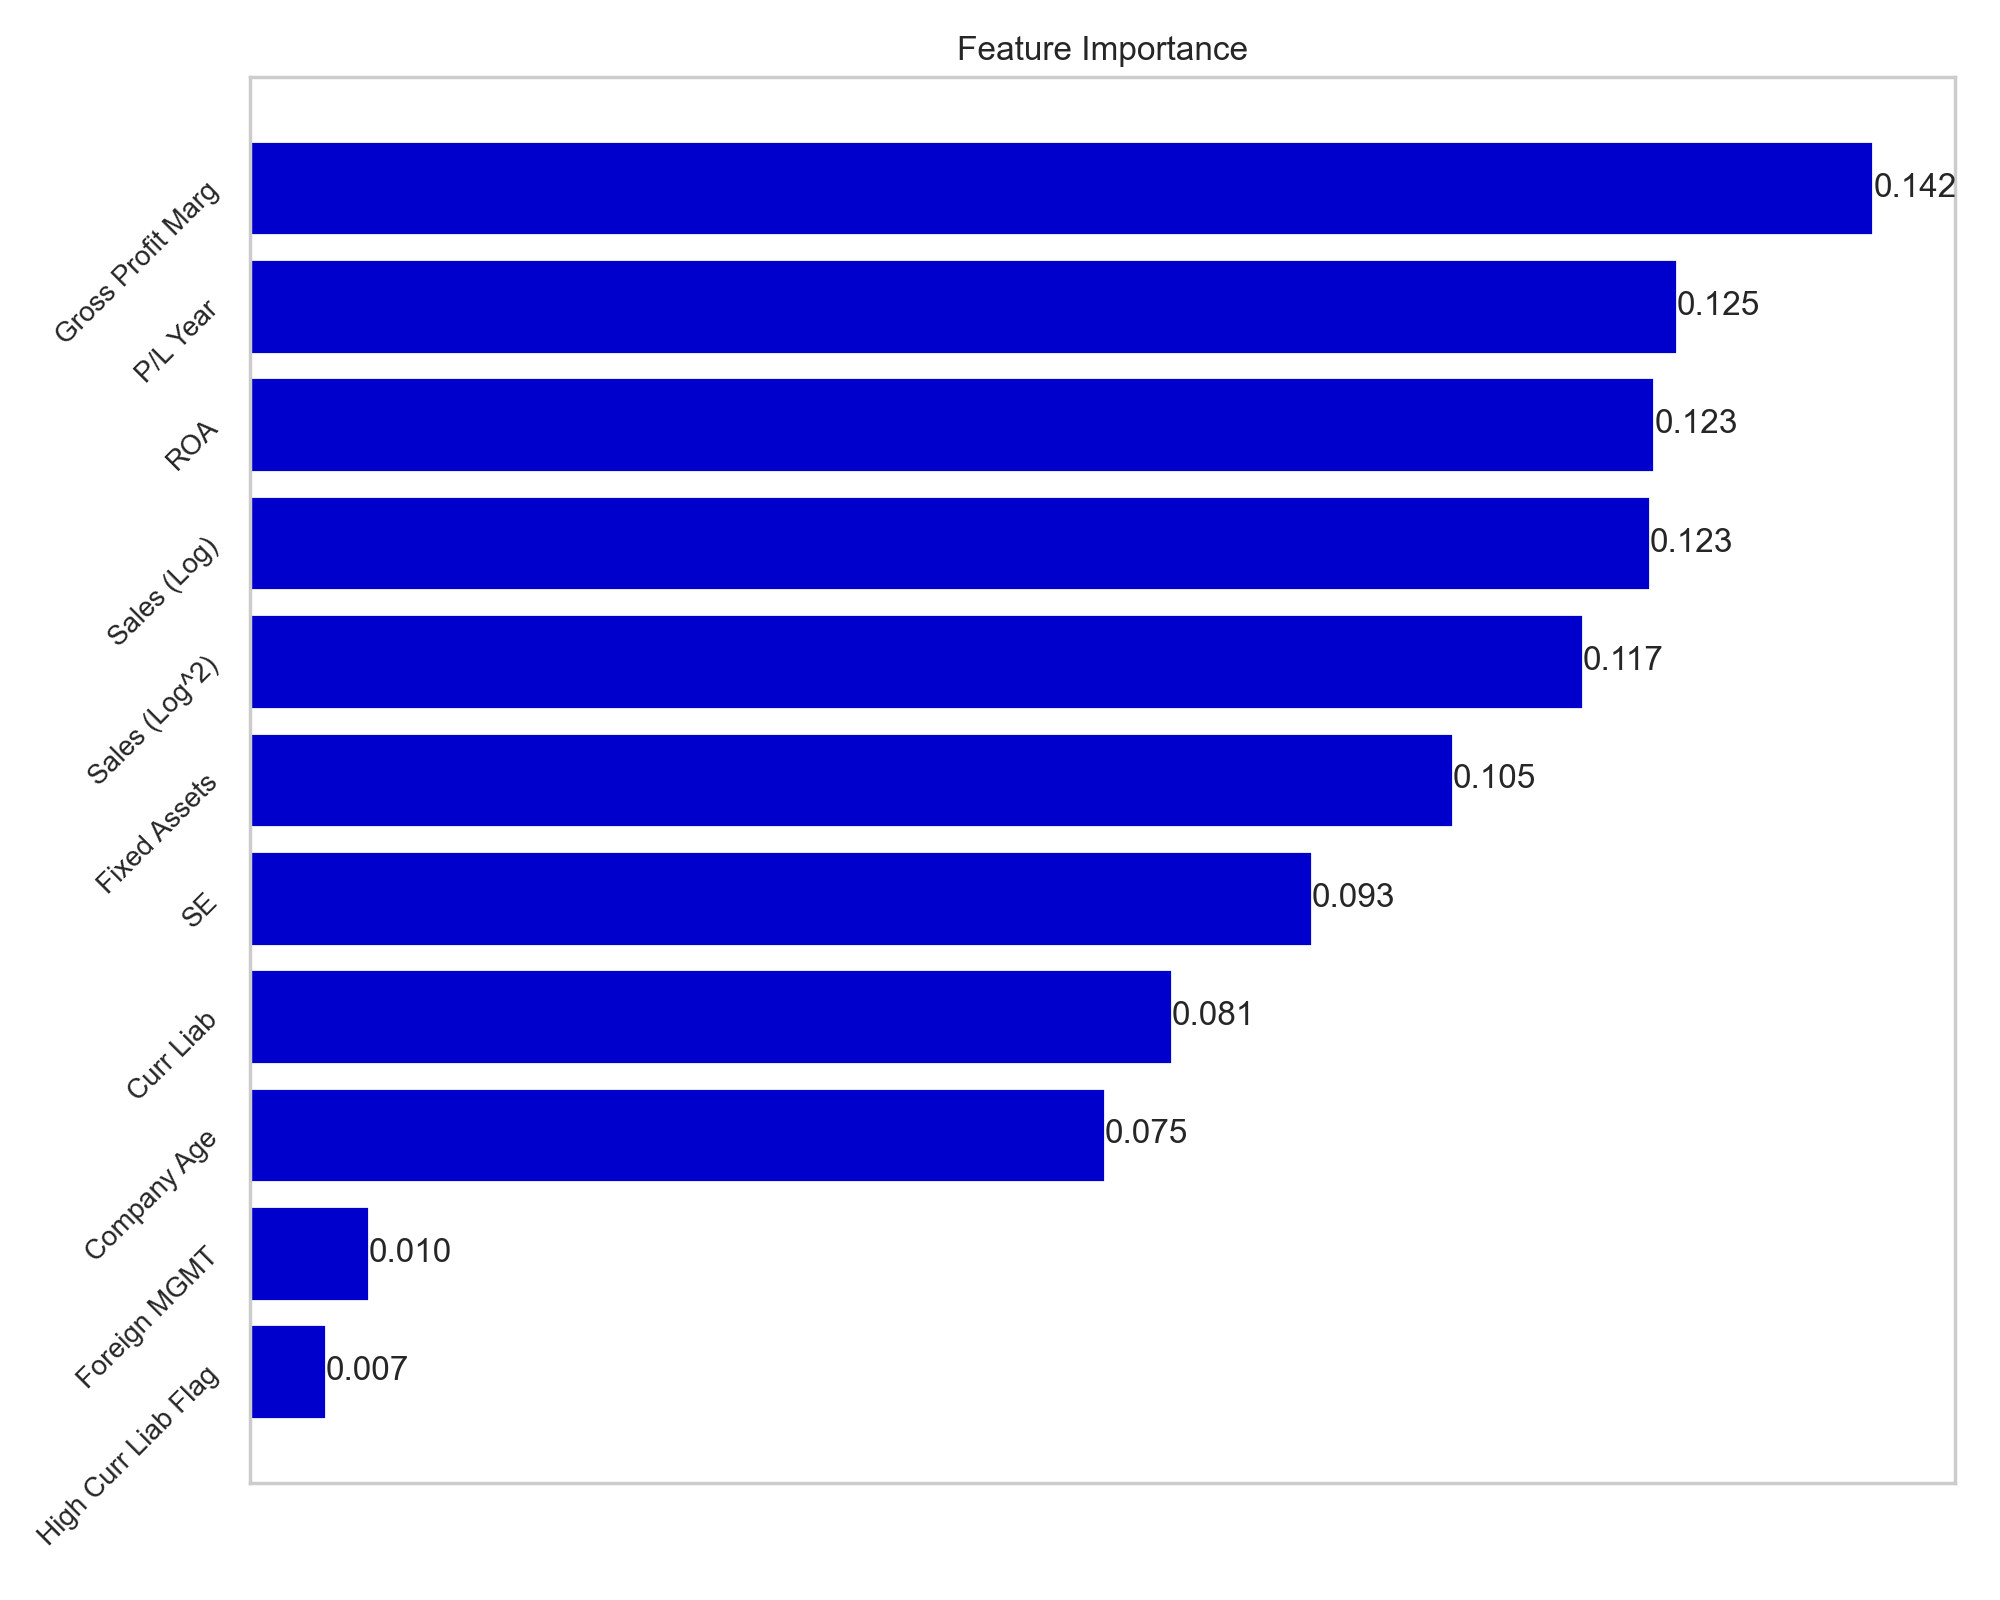

In [125]:
from sklearn.ensemble import RandomForestClassifier

# Selecting the variables of M2 variables from the training data and the target variable
X = data_train[M2]
y = data_train['default']

# Training the final model to the training data using the best parameters found
final_model = RandomForestClassifier(
    max_features=best_mtry,
    min_samples_split=best_min_node_size,
    random_state=42
)
final_model.fit(X, y)

# Defining the feature importance values for the final model
importances = final_model.feature_importances_

# Converting the feature importance values into a DataFrame using M2 for feature names
feature_importance_df = pd.DataFrame({'Feature': M2, 'Importance': importances})

# Sorting the values in a descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Mapping the original feature names for a better readability on the charts
feature_name_mapping = {
    'gross_profit_margin': 'Gross Profit Marg',
    'profit_loss_year_pl': 'P/L Year',
    'return_on_assets': 'ROA',
    'sales_mil_log': 'Sales (Log)',
    'sales_mil_log_sq': 'Sales (Log^2)',
    'fixed_assets_bs': 'Fixed Assets',
    'share_eq_bs': 'SE',
    'curr_liab_bs': 'Curr Liab',
    'age': 'Company Age',
    'foreign_management': 'Foreign MGMT',
    'curr_liab_bs_flag_high': 'High Curr Liab Flag'
}

# Applying the renaming to the DataFrame for plotting
feature_importance_df['Readable Feature'] = feature_importance_df['Feature'].map(feature_name_mapping)

# Plotting the feature importance values with an inverted axis to have the highest importance at the top
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importance_df['Readable Feature'], feature_importance_df['Importance'], color = 'mediumblue')
plt.xlabel('')
plt.ylabel('') 
plt.title('Feature Importance')
plt.gca().invert_yaxis()

# Adjusting y axis labels for a better readability
plt.yticks(rotation=45, fontsize=10)

# Removing the grid lines
plt.grid(False)

# Removing both major, minor x-axis ticks and labels
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adding the exact importance values next to each bar for clarity
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             '{:.3f}'.format(bar.get_width()),
             va='center', ha='left')

# Adjusting the layout for a better readability
plt.tight_layout()

# Create the Figures folder (of the CWD)
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    
# Saving the graph as a PNG file
plt.savefig("Figures/12_feature_importance.png", format='png')

plt.show()



The feature importance values for M2 model show that the most impactful variables are `gross_profit_margin`, `profit_loss_year_pl` and `return_on_assets`. `sales_mil_log` and `sales_mil_log_sq` have lower importance values, which is interesting, considering that sales is our target variable. This suggests that despite the target variable, factors beyond simple revenue figures play important roles in determining if a company defaulted or not. 

In [126]:
# Filtering the best results for cross-validation

prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
# Extracting the index with the best possible results
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [127]:
# Adding the RF results to the summary table
# We put n.a. because number of coefficients doesn't apply to RF the same as to linear models
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,6.0,0.229471,0.719717
M2,12.0,0.228539,0.754033
M3,26.0,0.228866,0.741943
M4,86.0,0.232480,0.732913
M5,79.0,0.226014,0.769907
M6,12.0,0.227458,0.733060
LASSO,19.0,0.225867,0.776757
RF,n.a.,0.222828,0.806722


In [128]:
# Adding the RMSE scores to the CV RMSE fold DataFrame
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

# Adding the AUC values to the CV AUC Folds DataFrame
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [129]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,M6,LASSO,RF
0,0.234284,0.234167,0.234823,0.232296,0.230047,0.235387,0.229624,0.227084
1,0.231376,0.230469,0.232167,0.232704,0.227570,0.231733,0.227242,0.225384
2,0.211670,0.212704,0.211624,0.215128,0.211772,0.207936,0.210647,0.204910
3,0.253208,0.248926,0.248310,0.257432,0.247569,0.245632,0.248321,0.243644
4,0.216818,0.216427,0.217407,0.224842,0.213111,0.216602,0.213500,0.210040


In [130]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,M6,LASSO,RF
0,0.710924,0.734856,0.739826,0.723119,0.771355,0.672997,0.756933,0.771841
1,0.753117,0.784717,0.737932,0.765100,0.785633,0.736330,0.797472,0.824125
2,0.682658,0.706969,0.699809,0.701173,0.752114,0.770322,0.745295,0.809482
3,0.711721,0.762226,0.779531,0.741192,0.764496,0.765261,0.803791,0.803934
4,0.740163,0.781398,0.752618,0.733984,0.775935,0.720390,0.780293,0.824228


## *AUC (Area Under the ROC Curve)*

--- 
Our AUC results for all of our models all range between 67 and 82, meaning that these models are 67 to 82% chance that the model will be able to distinguish between positive class and negative class.

In [131]:
# Initializing empty lists
best_thresholds = list()
expected_loss = list()

# Creating a DataFrame for RandomForest variables for the training set
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
# Looping through the folds and splitting the data
for train_index, test_index in k.split(rfvars_train):
    start_time = time.time()  # Start the timer for the fold
    
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]
    
    # Training the RandomForest classifier using the training data
    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    
    # Using the trained RF model to make predictions on the test data (X_fold)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    # Calculating the ROC curve using predicted probabilities and and the true labels ('y_fold') of the test data
    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    
    # Appending the optimal threshold to the best_threshold DataFrame
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    
    # Appending the expected loss to the curr_exp_loss
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)
    
    # Print the fold number and time taken for the fold
    end_time = time.time()  # End the timer for the fold
    print(f"Fold {fold+1} processed in {end_time - start_time:.2f} seconds.")

    fold += 1  # Increment the fold counter

# Storing the threshold and the expected loss of Fold 5
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

# Containing the DataFrame containing the metrics for different folds
all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


Fold 1 processed in 12.06 seconds.
Fold 2 processed in 12.27 seconds.
Fold 3 processed in 11.57 seconds.
Fold 4 processed in 12.13 seconds.
Fold 5 processed in 12.03 seconds.


In [132]:
# Calculating the mean of expetced loss and the best thresholds across all folds for the RF model 
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [133]:
# Summarizing the RF metrics in a DataFrame
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.223,0.807,0.229,0.141,0.713,0.649


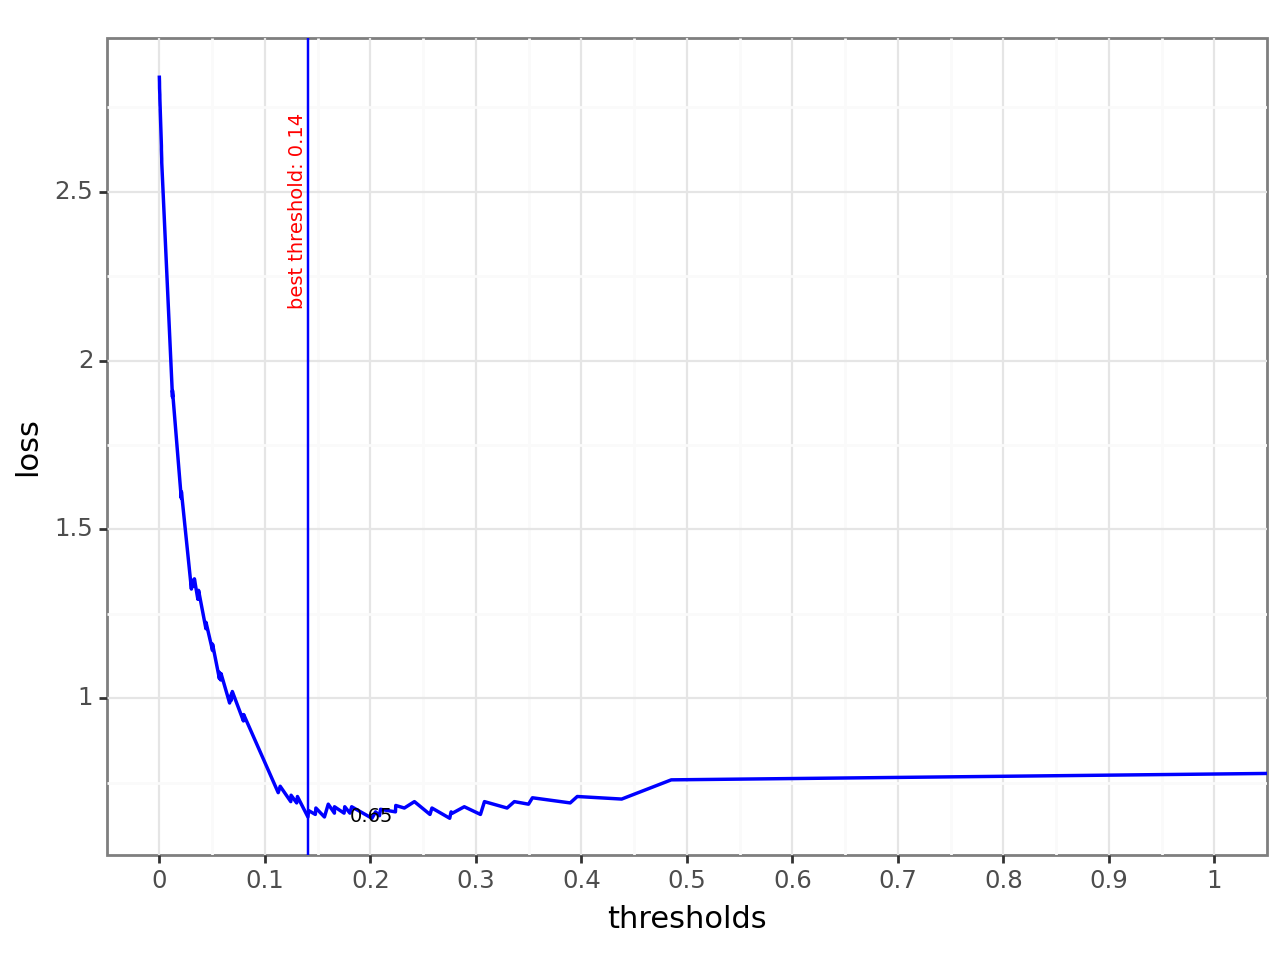

<Figure Size: (640 x 480)>

In [134]:
# Plotting the Expected Loss curve for Fold 5
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

#### Interpreting the plot of loss vs. threshold for RandomForest

The graph shows that for RandomForest for Fold5, setting the threshold to 0.14 minimizes the loss, hence it is the best threshold for this model according to the loss function used.

Similary, the loss values for higher threshold values are maximized around 0.5. This is true for all the above models, M2, LASSO and RandomForest. This suggests that as soon as the expected loss becomes 0.5 again, the models are essentially making random predictions regardless of the threshold chosen.

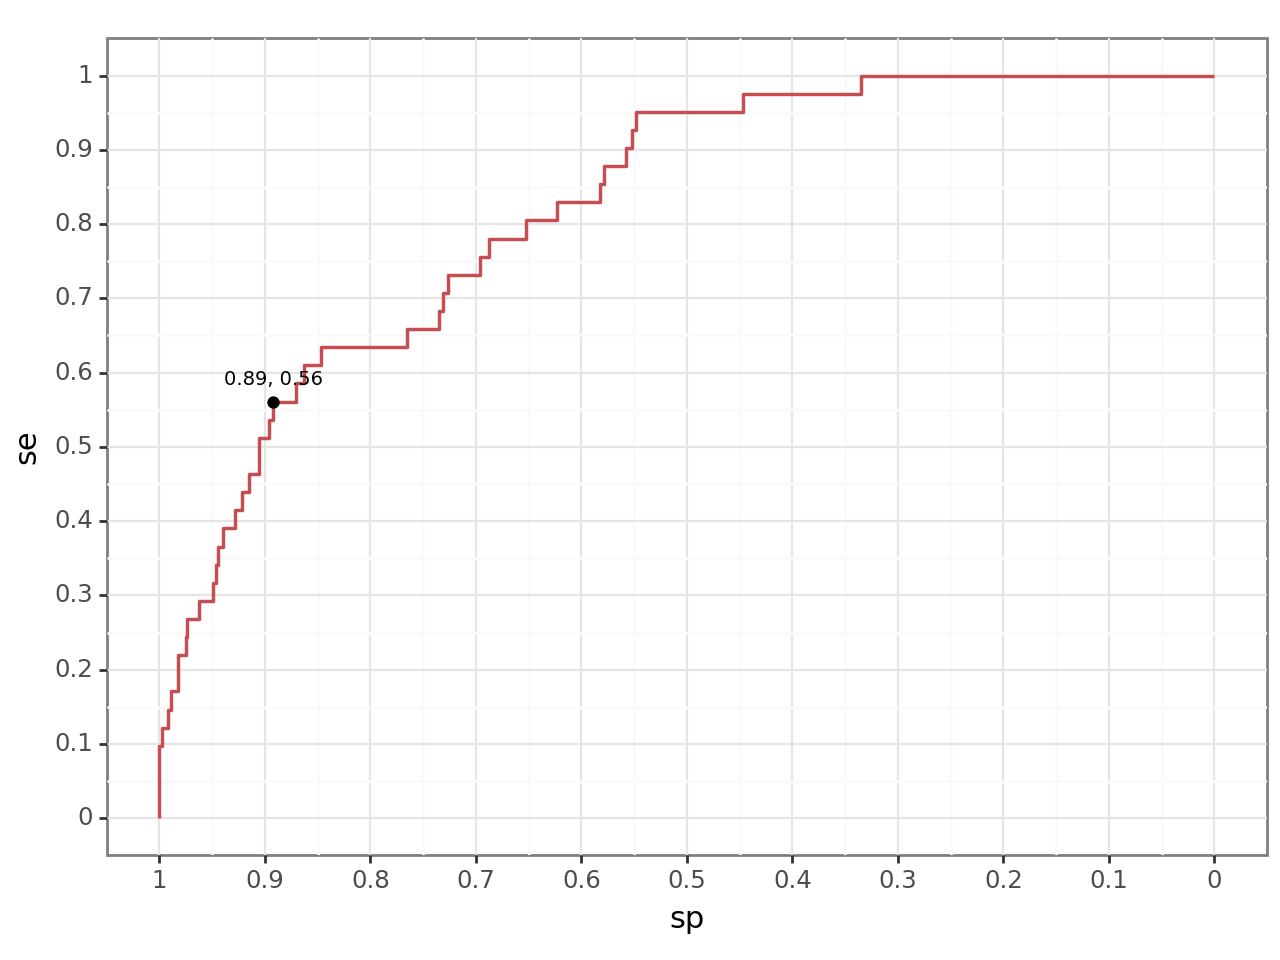

<Figure Size: (640 x 480)>

In [135]:
# Plotting the ROC curve with the optimal threshold for Fold 5
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

#### Interpreting the ROC scores for RandomForest
The point on the ROC curves shows the coordinates of the best optimal threshold for the RF model for Fold5, where the Specificity score is 0.89 and the Sensitivity score is 0.56. The x scale is backwards as the x axis on the original ROC curve graph is displayed as (1-Specificity).

## *Calculating metrics for the holdout set*
---

In [136]:
# Retrieving the best estimator
prob_forest_fit_best = prob_forest_fit.best_estimator_

# Predicting probabilities for the holdout set
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
# Calculating the RMSE on the hold out set
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.203

### *Calculating the ROC AUC on holdout*
---

In [137]:
# Calculating the ROC AUC score for the RF model on the holdout set
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.836

### *Calculating the expected loss on holdout*
---

In [138]:
# Checking id the positive class is above the optimal threshold, if its less than the threshold, it assings a 0
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)

# Creating a confusion matrix for the holdout set
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()

# Calculating the expected loss for the holdout set
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.584

# ***Gradient Boosting with cross-validation***
---

In [139]:
# Defining the cost of false positives and false negatives
FP_cost = 3
FN_cost = 15

# Preparing the training and testing datasets

# Extracting the predictor variable names from the training data, leaving out the target variable
grad_boost_columns = data_train.columns.drop('default')

# Selecting only the numerical features to avoid errors in the ML algos
X_train = data_train[grad_boost_columns].select_dtypes(include=np.number)

# Extracting the target variable
y_train = data_train['default']

# Selecting the numerical predictor variables from the holdout sample
X_test = hold_out_sample[grad_boost_columns].select_dtypes(include=np.number)

# Extracting the target variable
y_test = hold_out_sample['default']



# Initializing the K-Fold for cross-validation and GB Classifier
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Fitting the model on the training data
gb_clf.fit(X_train, y_train)

# Defining a function to find the optimal threshold from the ROC curve
def find_optimal_threshold(tpr, fpr, thresholds):
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

# Performing a cross-validation to calculate metrics
# AUC scores
auc_scores = cross_val_score(gb_clf, X_train, y_train, cv=kf, scoring='roc_auc')
print(f"CV AUC: {np.mean(auc_scores):.4f}")

# RMSE scores
mse_scores = -cross_val_score(gb_clf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)
print(f"CV RMSE: {np.mean(rmse_scores):.4f}")

# Predicting probabilities for calculating optimal threshold and expected loss
# Returning the predicted probabilities instead of classifications
y_probs_cv = cross_val_predict(gb_clf, X_train, y_train, cv=kf, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_probs_cv[:, 1])
optimal_threshold_gb = find_optimal_threshold(tpr, fpr, thresholds)
print(f"CV Threshold: {optimal_threshold_gb:.4f}")

# Making predictions using the optimal threshold
y_pred_cv = (y_probs_cv[:, 1] >= optimal_threshold).astype(int)

# Creating the confusion matrix and calculating the expected loss
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_cv).ravel()
expected_loss_cv_gb = (fp * FP_cost + fn * FN_cost) / len(y_train)
print(f"Expected Loss (CV): {expected_loss_cv_gb:.3f}")

# Predicting on the test set and evaluating the model
y_pred = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Setting AUC and RMSE variables for an easier reference in the summary table
gb_cv_rmse = np.mean(rmse_scores)
gb_cv_auc = np.mean(auc_scores)


CV AUC: 0.8543
CV RMSE: 0.2444
CV Threshold: 0.0325
Expected Loss (CV): 0.622
Accuracy: 0.9543


# ***Final Results***
---

In [140]:
# Summarizing the best thresholds and the expected loss
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [141]:
# Adding the GB results to the summary table using the .loc method
summary.loc["GB", "Number of Coefficients"] = 'n.a.'  # GB does not have coefficients in the traditional sense
summary.loc["GB", "CV RMSE"] = gb_cv_rmse  # replace with your calculated value
summary.loc["GB", "CV AUC"] = gb_cv_auc  # replace with your calculated value
summary.loc["GB", "CV treshold"] = optimal_threshold  # replace with your calculated value
summary.loc["GB", "CV expected Loss"] = expected_loss_cv_gb  # replace with your calculated value

In [142]:
summary


,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,6.0,0.229471,0.719717,0.145796,0.789422
M2,12.0,0.228539,0.754033,0.168825,0.759846
M3,26.0,0.228866,0.741943,0.150263,0.770463
M4,86.0,0.232480,0.732913,0.142701,0.777281
M5,79.0,0.226014,0.769907,0.123653,0.745446
M6,12.0,0.227458,0.733060,0.171528,0.746953
LASSO,19.0,0.225867,0.776757,0.135601,0.747717
RF,n.a.,0.222828,0.806722,0.228923,0.712832
GB,n.a.,0.244355,0.854283,0.132717,0.621840


We opted the number of coefficients for RF and GB as *NA*, because the number of variables in these model are not directly interpretable or relevant for understanding their performance or results compared to other linear models.

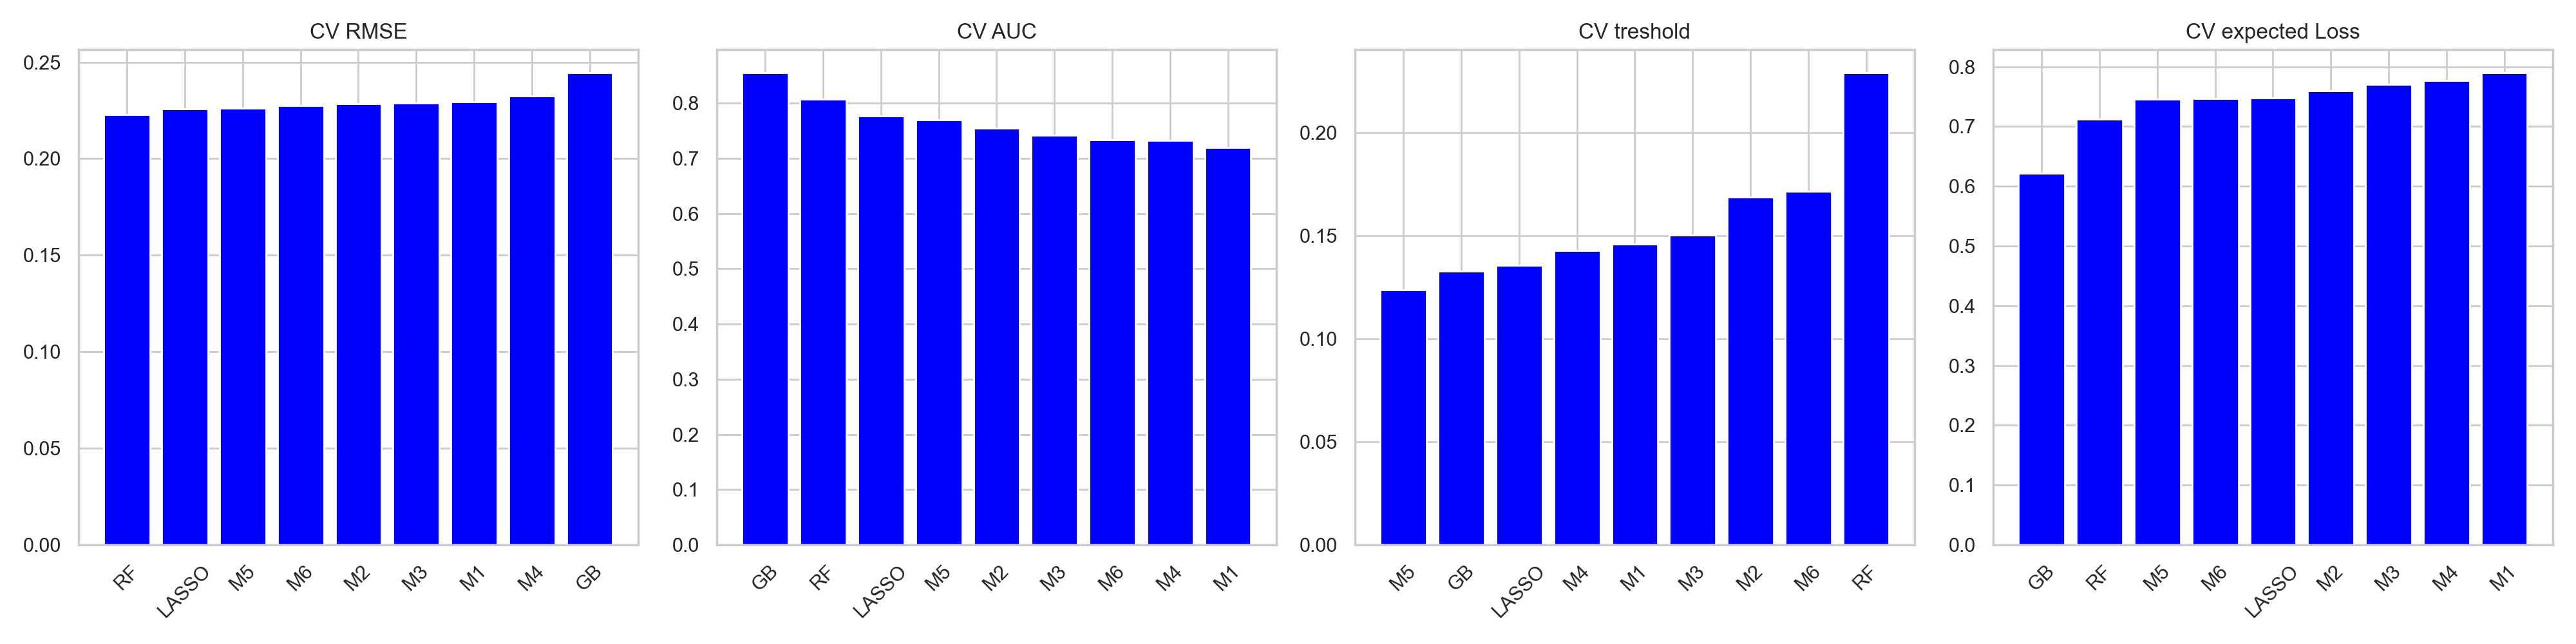

In [143]:
# Function for setting ascending True or False on certain summary columns depending on their value type
def custom_sort(df, col, ascending):
    return df.sort_values(by=col, ascending=ascending)

# Plotting bar charts for the last four columns with custom sorting
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

# Defining the sorting order for each column
sort_orders = {
    'CV RMSE': True,
    'CV treshold': True,
    'CV expected Loss': True,
    'CV AUC': False
}

# Iterating over the columns containing the scores to create bar charts
for i, column in enumerate(summary.columns[-4:]):
    # Sorting the summary DataFrame by the current column using the custom sort function
    sorted_summary = custom_sort(summary, column, sort_orders[column])
    
    #Setting the parameters of the barcharts
    axes[i].bar(sorted_summary.index, sorted_summary[column], color='blue')
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

# Adjusting the plot for better readability
plt.tight_layout()

# Creating the Figures folder (if Figured folder does not exist)
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder
plt.savefig("Figures/15_summary_comparisons.png", format='png')

plt.show()


#### **Interpreting the final evaluation criterias**
- The CV RMSE values range from 0.229 to 0.244, with the RF obtaining the best value (0.223). 
- The AUC scores range between 0.71 until 0.85, with GB model obtaining the best value (0.854).
- Among all criteria, the most largest difference between models lie in the threshold values. Namely, the threshold for M5 stands at 0.769, meanwhile the highest threshold is observed in the RandomForest model at 0.229.
- GB obtains lowest expected loss with the value of 0.621. All the other models' expected loss range between 0.71 to 0.79. Expected loss directly integrate the costs associated with different types of prediction errors, we can consider this as the decisive criteria, indicating that - based on the training set - GB is our best performing model.

# ***Testing M2 on the Holdout Sample***
---

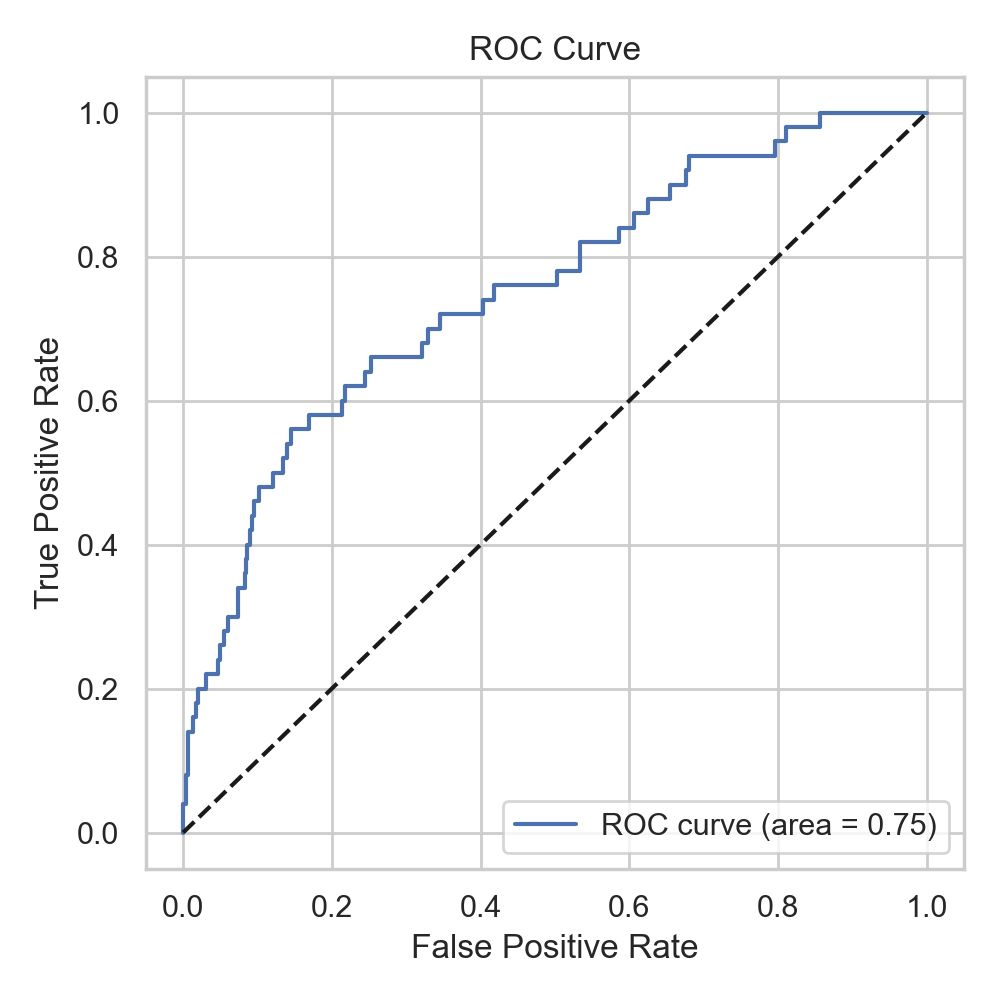

Trained Random Forest Predicting Holdout Sample Metrics
-------------------------------------------------------


,Metric,Value
0,RMSE,0.208
1,Brier Score,0.043
2,ROC AUC,0.752
3,Accuracy,0.908
4,Sensitivity,0.280
5,Specificity,0.940
6,Expected Loss,0.707
7,Optimal Threshold,0.133
8,Total Number of Firms on the holdout set,1006.000
9,Firms Defaulted,50.000


In [144]:
# Prepare the hold_out_sample data
model_equation = "default~" + "+".join(logit_model_vars[1])  # M2 model variables
y_holdout, X_holdout = patsy.dmatrices(model_equation, hold_out_sample)

# Predict on the hold_out_sample using the trained M2 model
model_M2 = logit_models["M2"]
prob_predictions = model_M2.predict_proba(X_holdout)[:, 1]

# Calculate binary predictions based on the optimal threshold
binary_predictions_optimal = (prob_predictions >= optimal_threshold).astype(int)

# Evaluate the model's performance
rmse_holdout = np.sqrt(mean_squared_error(y_holdout, prob_predictions))
brier_score_holdout = brier_score_loss(y_holdout, prob_predictions)
roc_auc_holdout = roc_auc_score(y_holdout, prob_predictions)
accuracy_optimal = accuracy_score(y_holdout, binary_predictions_optimal)

# Confusion matrix for optimal threshold
tn, fp, fn, tp = confusion_matrix(y_holdout, binary_predictions_optimal).ravel()
sensitivity_optimal = tp / (tp + fn)
specificity_optimal = tn / (tn + fp)

# Calculate expected loss
loss_fn = 15  # Loss for a false negative
loss_fp = 3   # Loss for a false positive
expected_loss_optimal = (fn * loss_fn + fp * loss_fp) / len(y_holdout)

# Descriptive statistics
num_firms = len(hold_out_sample)
firms_defaulted = int(fn + tp)
firms_stayed_alive = int(tn + fp)
mean_sales = hold_out_sample['sales'].mean()  
min_sales = hold_out_sample['sales'].min()
max_sales = hold_out_sample['sales'].max()

# Create a summary table with the evaluation metrics and descriptive statistics
summary_table = pd.DataFrame({
    'Metric': ['RMSE', 'Brier Score', 'ROC AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Expected Loss',
               'Optimal Threshold', 'Total Number of Firms on the holdout set', 'Firms Defaulted', 'Firms Stayed Alive', 
               'Mean Sales', 'Min Sales', 'Max Sales'],
    'Value': [rmse_holdout, brier_score_holdout, roc_auc_holdout, accuracy_optimal, sensitivity_optimal, 
              specificity_optimal, expected_loss_optimal, optimal_threshold, num_firms, firms_defaulted, 
              firms_stayed_alive, mean_sales, min_sales, max_sales]
})


# Round the 'Value' column to three decimal places
summary_table['Value'] = summary_table['Value'].apply(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)


# Generate plots - ROC Curve
plt.figure(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(y_holdout, prob_predictions)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_holdout:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()

# Create Figures folder if Figured folder does not exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file in the 'Figures' folder of the CWD
plt.savefig("Figures/16_M2_ROC.png", format='png')

plt.show()

# Display the summary table
print("Trained Random Forest Predicting Holdout Sample Metrics")
print("-"*55)
summary_table


Testing M2 on our holdout and comparing to the training set, the RMSE score decreased to 0.208, the AUC slightly decreased from 0.754 to 0.752. The optimal threshold decreased from 0.169 to 0.133. Most importantly, the expected loss on the hold out set decreased from 0.76 to 0.707, suggesting that the M2 model performs better on the holdout set than on the training set. This leads to more accurate predictions and better decision making in real-world applications.


# ***Testing RandomForest on the Holdout Sample***
---

                 Predicted Negative  Predicted Positive
Actual Negative                 925                  31
Actual Positive                  33                  17


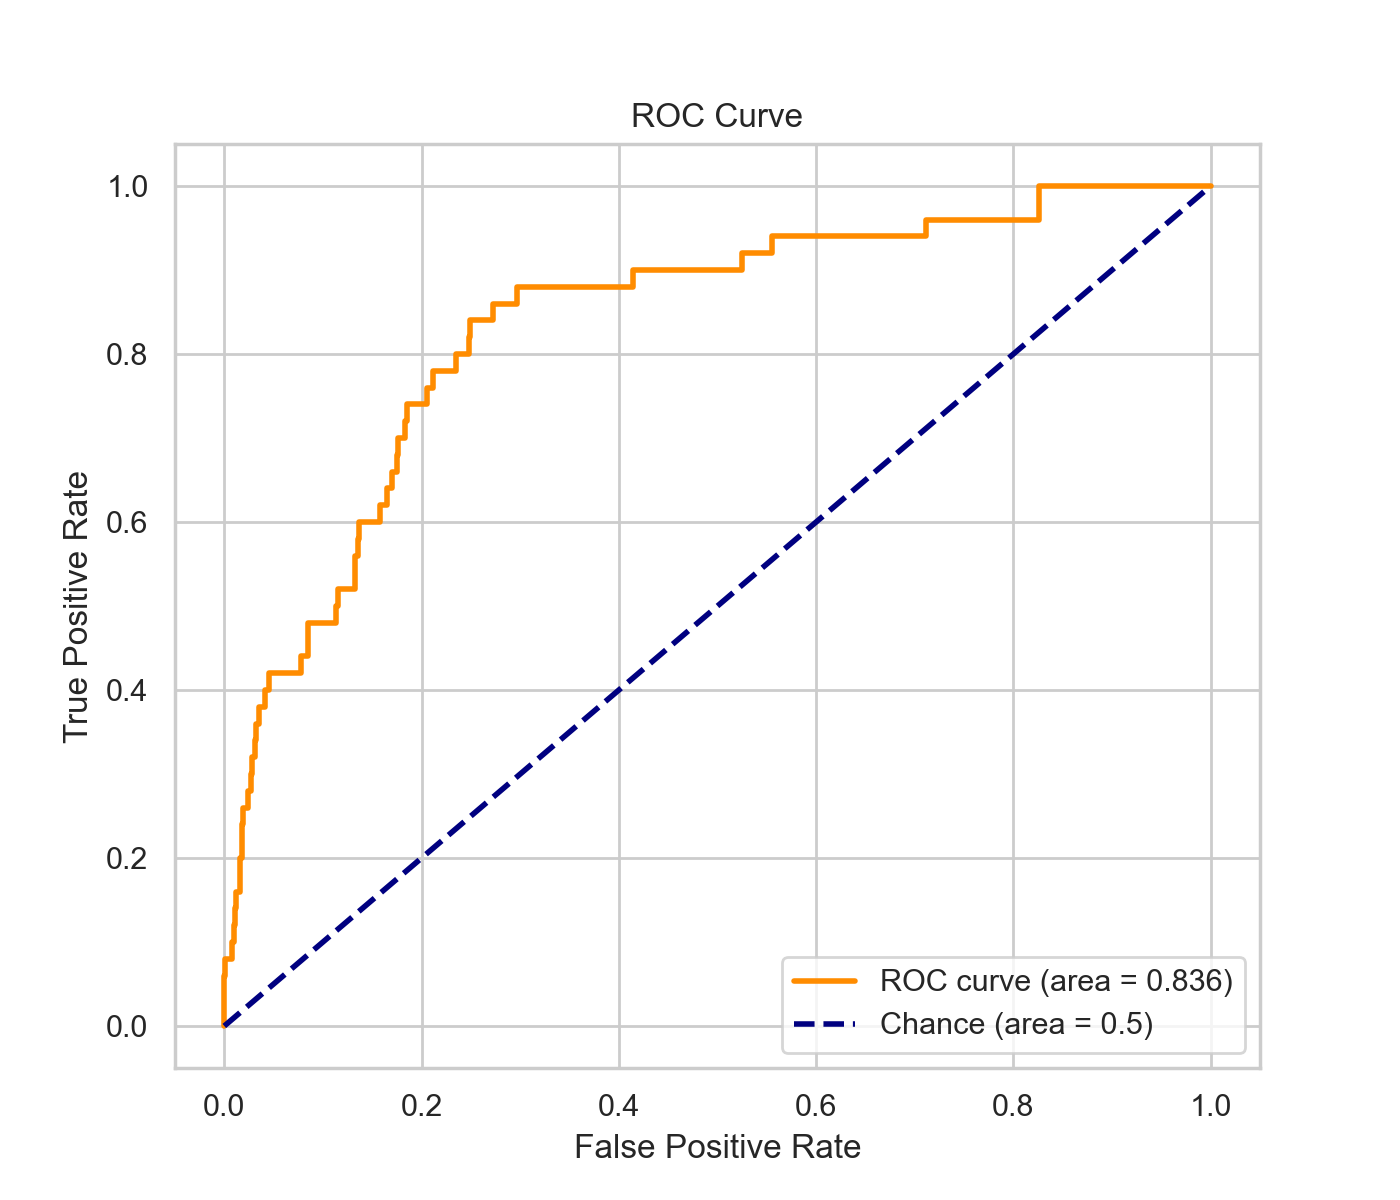

Trained Random Forest Predicting Holdout Sample Metrics
-------------------------------------------------------


,Metric,Value
0,RMSE,0.203
1,Brier Score,0.041
2,ROC AUC,0.836
3,Accuracy,0.936
4,Sensitivity,0.340
5,Specificity,0.968
6,Expected Loss,0.584
7,Optimal Threshold,0.229
8,Total Number of Firms on the holdout set,1006.000
9,Firms Defaulted,50.000


In [145]:
# Constants for the expected loss calculation
FP = 3 
FN = 15

# prob_forest_fit.best_estimator_ is the trained Random Forest best estimator
# and rfvars_holdout is the feature set for the holdout data
# Also assuming y_holdout is the true label for the holdout data

# Predicting probabilities for the holdout set using the best RF model
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:, 1]

# Calculating the RMSE for the holdout set
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))

# Calculating the Brier score for the RF model on the holdout set
brier_score_rf = brier_score_loss(y_holdout, rf_predicted_probabilities_holdout)

# Calculating the ROC AUC score for the RF model on the holdout set
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)

# Using best_thresholds_cv dictionary that contains the optimal threshold for the RF model
optimal_threshold = best_thresholds_cv["RF"]

# Performing binary prediction based on the optimal threshold
holdout_treshold = np.where(rf_predicted_probabilities_holdout < optimal_threshold, 0, 1)

# Creating a confusion matrix for the holdout set
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold).ravel()

# Create a DataFrame from the confusion matrix to display the table
confusion_df = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)
print(confusion_df)

# Calculating the expected loss for the holdout set
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)

# Calculating the accuracy, sensitivity, specificity
accuracy_rf = (tp + tn) / (tp + tn + fp + fn)
sensitivity_rf = tp / (tp + fn)
specificity_rf = tn / (tn + fp)

# Defining some descriptive statistics for the holdout set for conclusion
num_firms = len(y_holdout)
firms_defaulted = fn + tp
firms_stayed_alive = tn + fp
mean_sales = hold_out_sample['sales'].mean()
min_sales = hold_out_sample['sales'].min()
max_sales = hold_out_sample['sales'].max()

# Creating the DataFrame with all the metrics and rounding them
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'Brier Score', 'ROC AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Expected Loss', 'Optimal Threshold',
               'Total Number of Firms on the holdout set', 'Firms Defaulted', 'Firms Stayed Alive', 'Mean Sales', 'Min Sales', 'Max Sales'],
    'Value': [rmse_rf, brier_score_rf, auc_rf, accuracy_rf, sensitivity_rf, specificity_rf, expected_loss_holdout, optimal_threshold,
              num_firms, firms_defaulted, firms_stayed_alive, mean_sales, min_sales, max_sales]
})
metrics_df['Value'] = metrics_df['Value'].round(3)


# Calculating the FPR, TPR, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_holdout, rf_predicted_probabilities_holdout)

# Plotting the ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (area = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Creating Figures folder (if Figured folder does not exist)
if not os.path.exists('Figures'):
    os.makedirs('Figures')

# Saving figure as a PNG file
plt.savefig("Figures/17_RF_ROC.png", format='png')

plt.show()

# Displaying the metrics DataFrame
print("Trained Random Forest Predicting Holdout Sample Metrics")
print("-"*55)
metrics_df


Testing our RF model on the holdout set, we can observe that the RMSE value decreased by 0.017, AUC increased by 0.03, the optimal threshold remained 0.229 but the expected loss shifted from 0.712 to 0.584.

RMSE        AUC         threshold   expected loss
0.222828	0.806722	0.228923	0.712832

# ***Testing Gradient Boosting on the Holdout Sample***
---

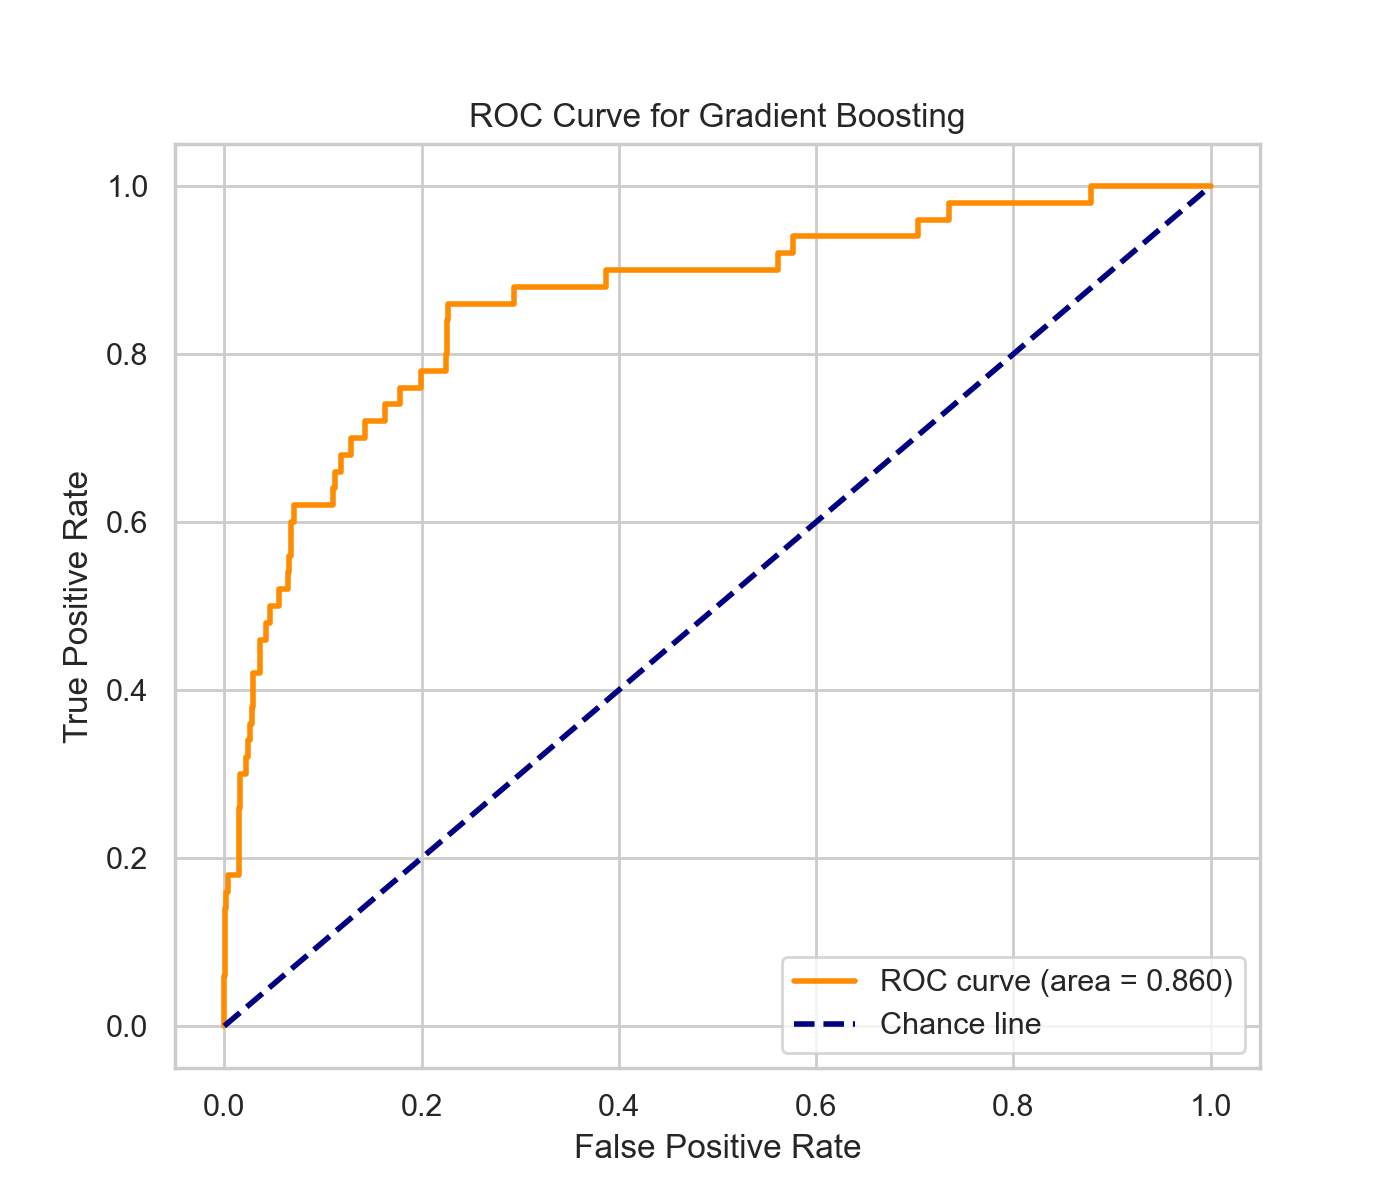

Gradient Boosting Performance on Holdout Set
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                 755                 201
Actual Positive                  11                  39


           Metric  Value
             RMSE  0.197
      Brier Score  0.039
          ROC AUC  0.860
    Expected Loss  0.763
Optimal Threshold  0.033


In [146]:
# Defining cost of false positives and false negatives
FP_cost = 3
FN_cost = 15

# Initializing Gradient Boosting Classifier and fitting on training data
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Predicting probabilities on the holdout set
gb_predicted_probabilities_holdout = gb_clf.predict_proba(X_test)[:, 1]

# Calculating metrics for Gradient Boosting on holdout set
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_predicted_probabilities_holdout))
brier_score_gb = brier_score_loss(y_test, gb_predicted_probabilities_holdout)
auc_gb = roc_auc_score(y_test, gb_predicted_probabilities_holdout)

# Assuming optimal_threshold_gb is the threshold you've calculated during training/validation
holdout_threshold_gb = np.where(gb_predicted_probabilities_holdout < optimal_threshold_gb, 0, 1)

# Constructing the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, holdout_threshold_gb).ravel()
confusion_df_gb = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

# Calculating expected loss for Gradient Boosting on holdout set
expected_loss_holdout_gb = (fp * FP_cost + fn * FN_cost) / len(y_test)

# Summarizing all the metrics into a DataFrame
metrics_df_gb = pd.DataFrame({
    'Metric': ['RMSE', 'Brier Score', 'ROC AUC', 'Expected Loss', 'Optimal Threshold'],
    'Value': [rmse_gb, brier_score_gb, auc_gb, expected_loss_holdout_gb, optimal_threshold_gb]
}).round(3)

# Plotting the ROC curve for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_predicted_probabilities_holdout)
plt.figure(figsize=(7, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {auc_gb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)

# Ensuring the 'Figures' directory exists
os.makedirs('Figures', exist_ok=True)

# Saving the ROC curve figure
plt.savefig("Figures/18_GB_ROC_Curve.png", format='png')
plt.show()

# Printing the results
print("Gradient Boosting Performance on Holdout Set")
print("-" * 55)
print(confusion_df_gb)
print("\n")
print(metrics_df_gb.to_string(index=False))
